In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
visitation = pd.read_csv('Visitation Data.csv')
climate = pd.read_csv('Weather Data.csv')

In [212]:
visitation.head()

Year  Week  Mt. Baw Baw  Mt. Stirling  Mt. Hotham  Falls Creek  \
0  2014.0   1.0        555.0          60.0      3483.0       2790.0   
1  2014.0   2.0        804.0          42.0      1253.0       1425.0   
2  2014.0   3.0        993.0          30.0      2992.0       2101.0   
3  2014.0   4.0       2976.0         165.0      9680.0       9544.0   
4  2014.0   5.0      11112.0         645.0     29628.0      26211.0   

   Mt. Buller  Selwyn  Thredbo  Perisher  Charlotte Pass  
0      8296.0  1041.0   5535.0    7370.0           408.0  
1      1987.0   383.0   2090.0    2751.0           151.0  
2      2413.0   597.0   3216.0    4255.0           230.0  
3     18831.0  2877.0  15497.0   20265.0          1134.0  
4     49217.0  8588.0  46546.0   61339.0          3403.0

In [213]:
visitation = visitation.iloc[:165,:]
visitation.describe()

Year        Week   Mt. Baw Baw  Mt. Stirling    Mt. Hotham  \
count   165.000000  165.000000    165.000000    165.000000    165.000000   
mean   2019.000000    8.000000   5373.648485    589.981818  20110.333333   
std       3.171904    4.333646   3924.269031    529.497558  12198.935589   
min    2014.000000    1.000000      0.000000      0.000000      0.000000   
25%    2016.000000    4.000000   1757.000000     98.000000   8368.000000   
50%    2019.000000    8.000000   5565.000000    480.000000  21856.000000   
75%    2022.000000   12.000000   8513.000000    962.000000  30944.000000   
max    2024.000000   15.000000  18031.000000   2097.000000  44648.000000   

        Falls Creek    Mt. Buller        Selwyn       Thredbo      Perisher  \
count    165.000000    165.000000    165.000000    165.000000    165.000000   
mean   24027.145455  29349.296970   5536.533333  30020.884848  39649.515152   
std    14176.688461  17768.711945   3383.338655  18363.819945  24258.783674   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     8741.000000  12397.000000   2180.000000  11543.000000  15236.000000   
50%    28099.000000  33328.000000   6454.000000  34676.000000  46265.000000   
75%    36692.000000  44315.000000   8530.000000  46015.000000  60788.000000   
max    49697.000000  66326.000000  12863.000000  70634.000000  93226.000000   

       Charlotte Pass  
count      165.000000  
mean      2181.812121  
std       1334.790842  
min          0.000000  
25%        842.000000  
50%       2542.000000  
75%       3344.000000  
max       5033.000000

# EDA

<Axes: ylabel='Count'>

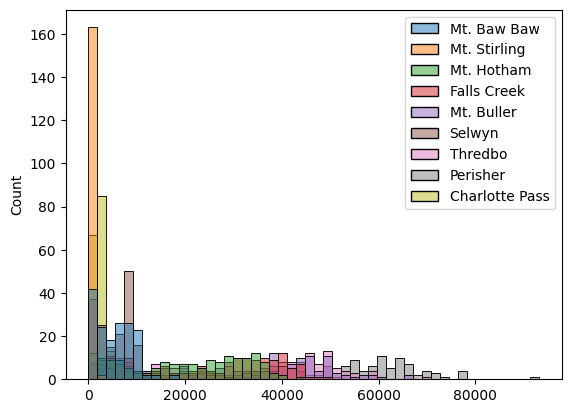

In [272]:
sns.histplot(snow_locations, bins = 50)

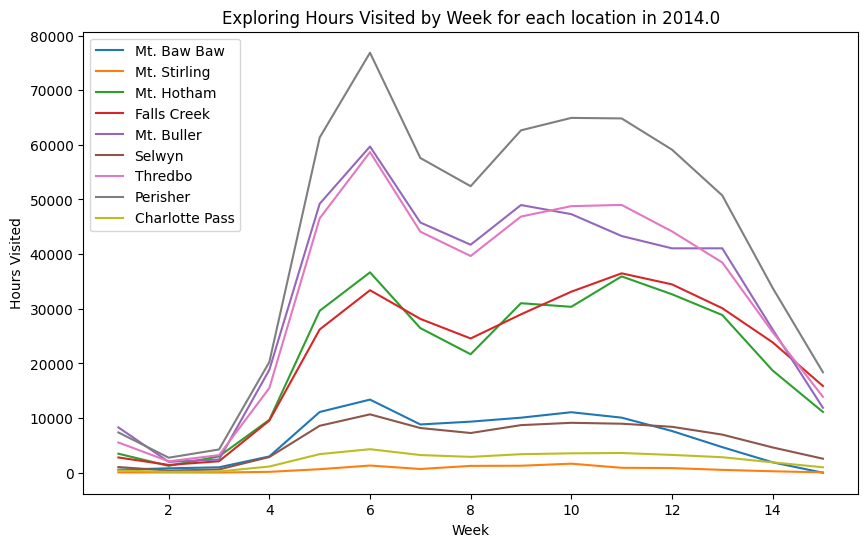

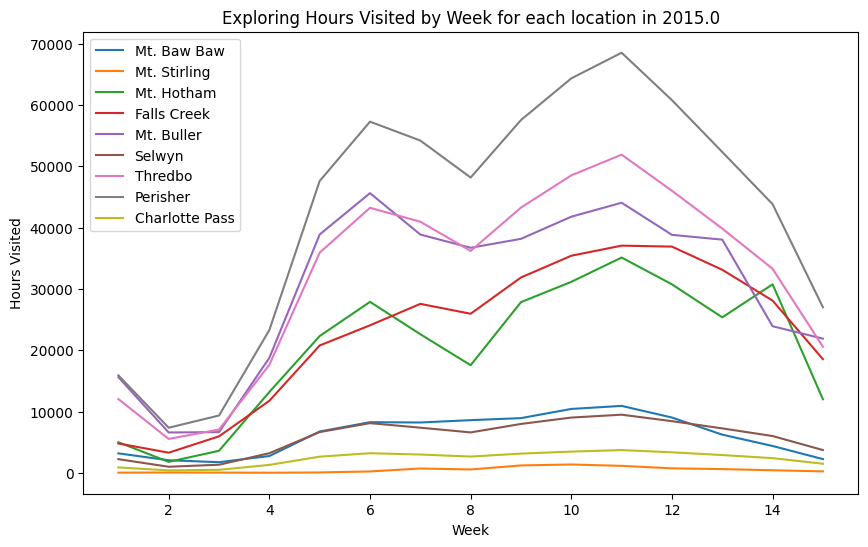

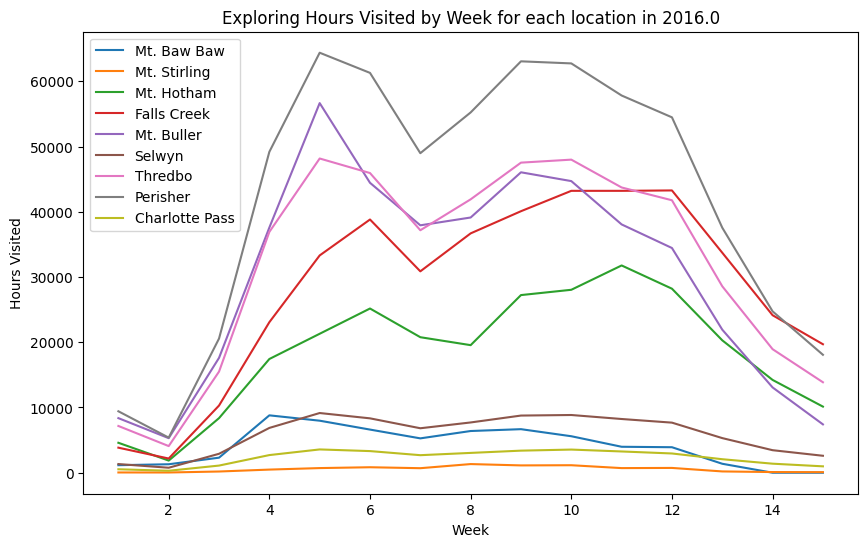

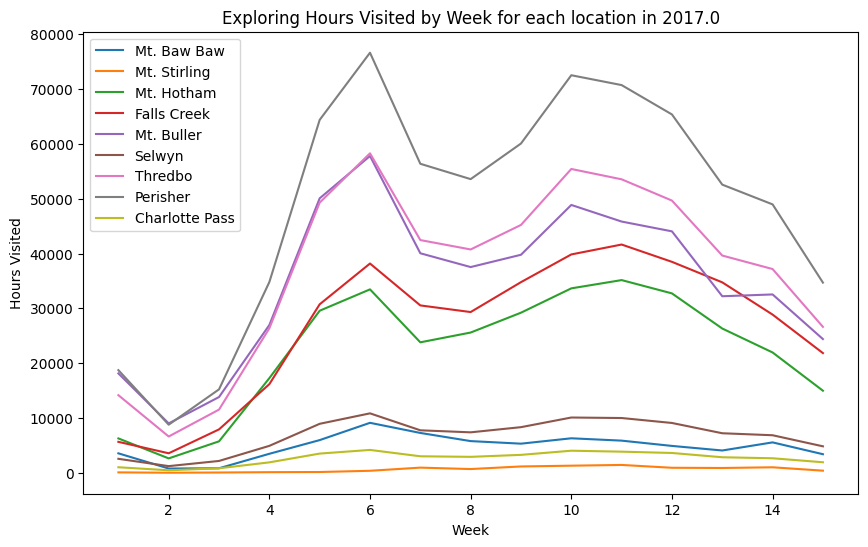

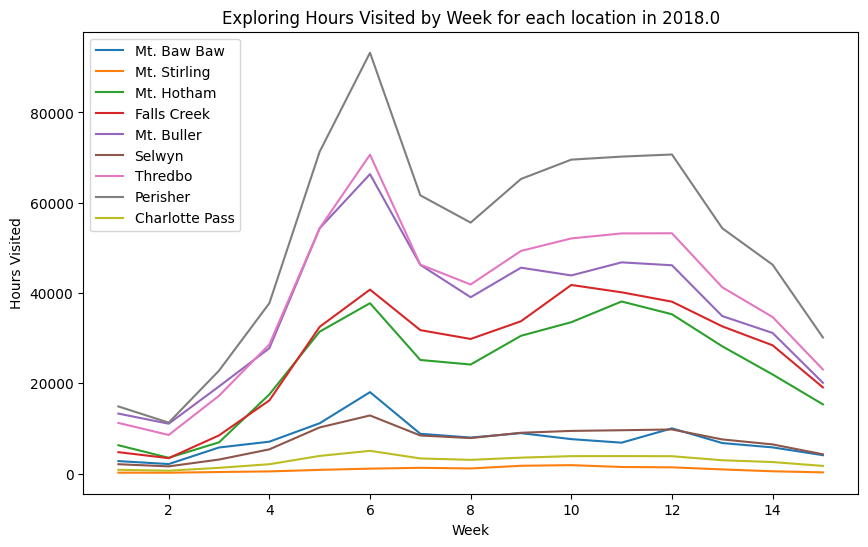

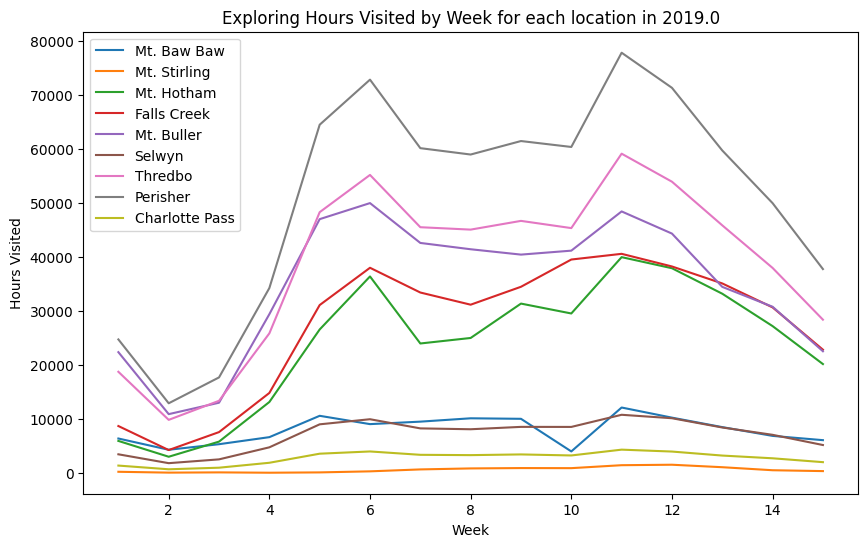

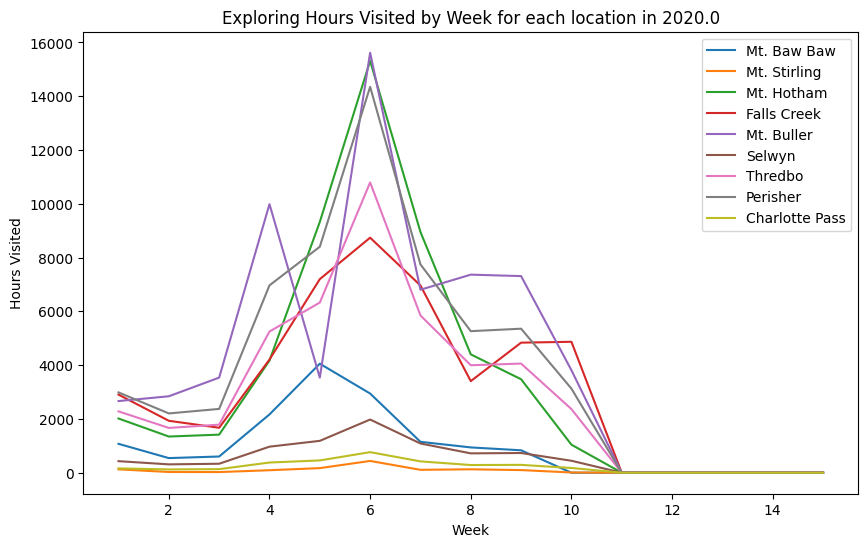

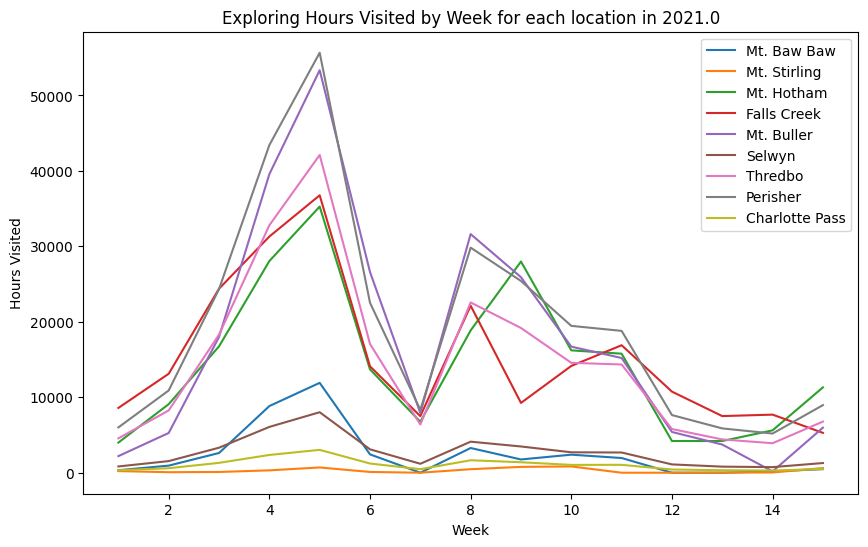

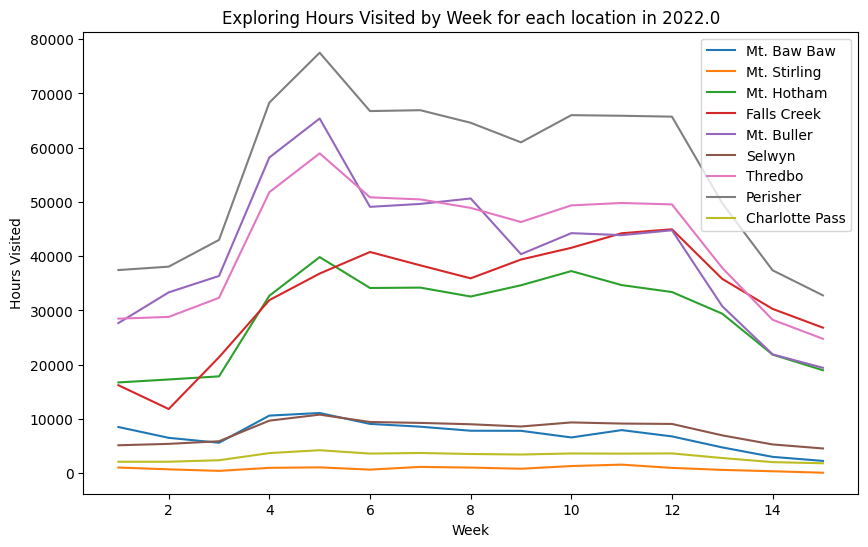

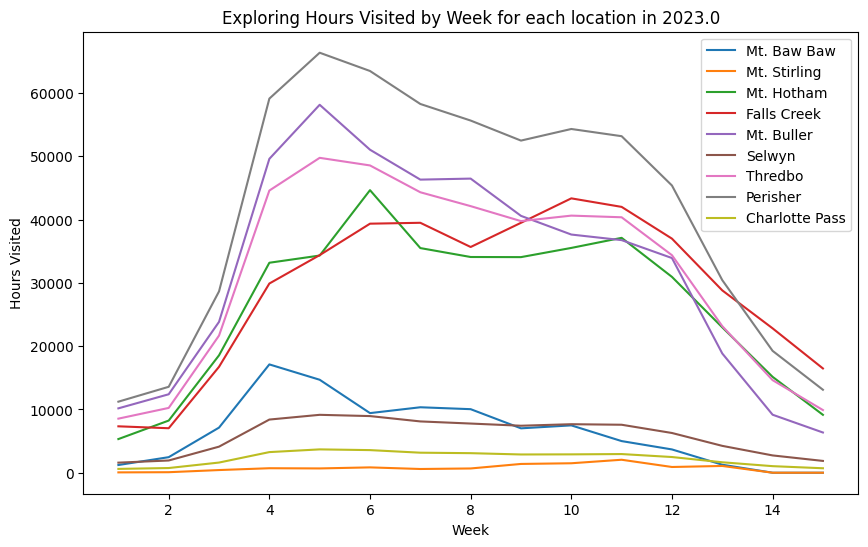

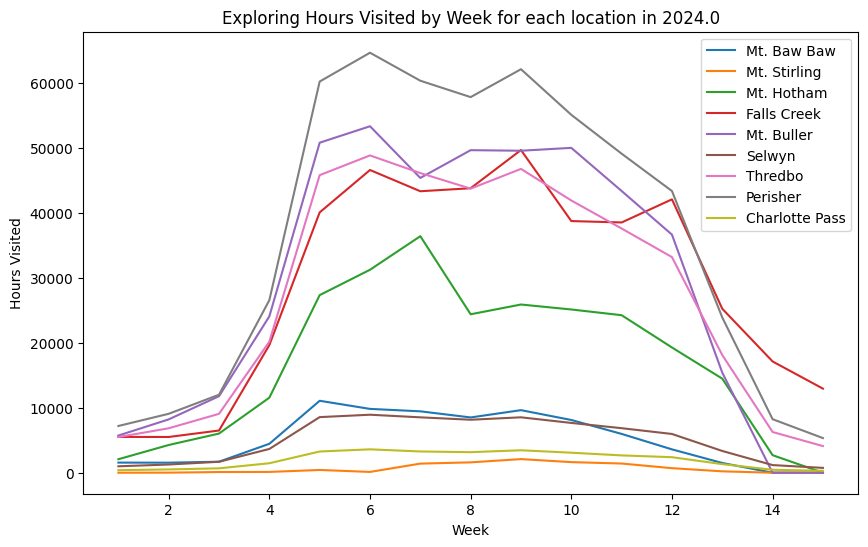

In [262]:
years = visitation['Year'].unique()

locations = [col for col in visitation.columns if col not in ['Year', 'Week']]

for year in sorted(years):
    visitation_year = visitation[visitation['Year'] == year]
    
    plt.figure(figsize=(10,6))
    for loc in locations:
        plt.plot(visitation_year['Week'], visitation_year[loc], label=loc)
    
    plt.xlabel("Week")
    plt.ylabel("Hours Visited")
    plt.title(f"Exploring Hours Visited by Week for each location in {year}")
    plt.legend()
    plt.show()

The graphs above showcase the weekly visitation trends by resort for each year (2014-2024). We can see that Perisher has the highest value for each one, followed by Thredbo and Mt. Buller. We also notice a bimodal pattern from 2014 to 2019, with 2 peaks around Week 6 and Week 11 respectively. However, post-2020 sees a unimodal pattern with a consistent peak around Week 8.

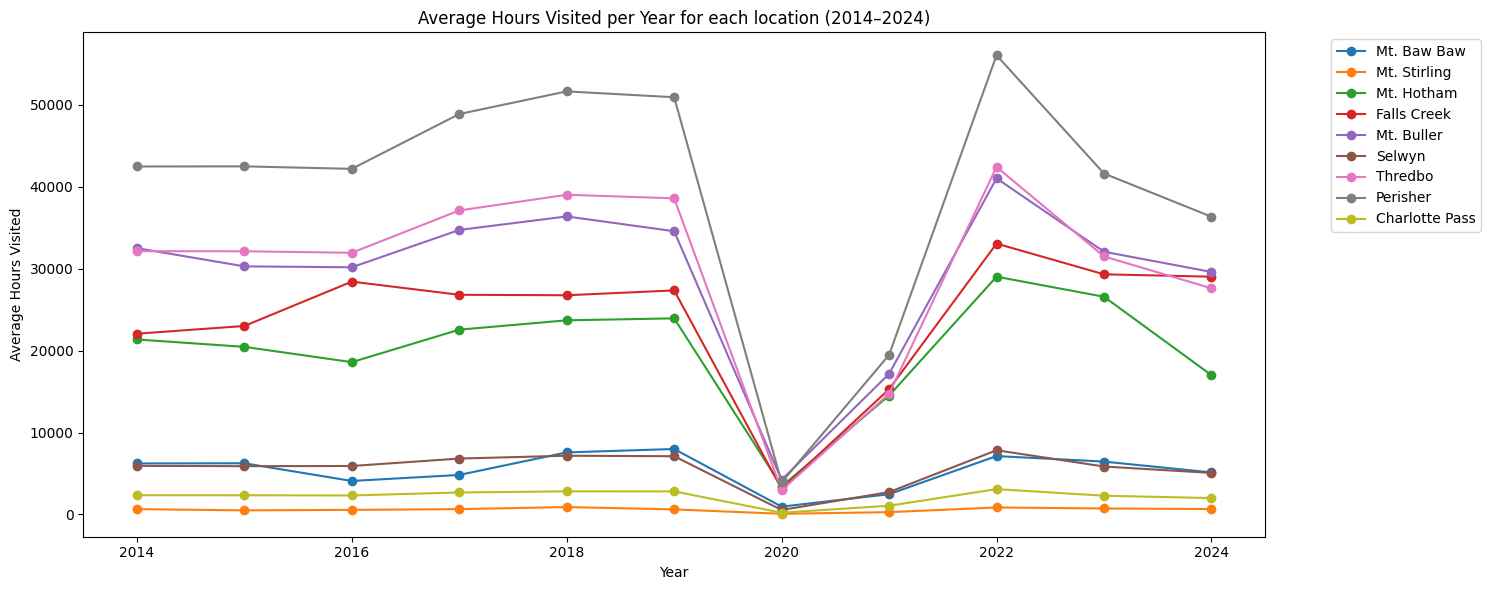

In [270]:
visitation_yearly = visitation.groupby("Year")[locations].mean()

plt.figure(figsize=(15,6))
for loc in locations:
    plt.plot(visitation_yearly.index, visitation_yearly[loc], marker='o', label=loc)

plt.xlabel("Year")
plt.ylabel("Average Hours Visited")
plt.title("Average Hours Visited per Year for each location (2014–2024)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The graph shows the average weekly visitation for each ski resort, aggregated into a single yearly value. Similar to the weekly trends, Perisher, Thredbo, and Mt. Buller record the highest average visitation. A notable feature is the sharp decline in 2020, which aligns with the impact of COVID-19 restrictions.

# Dataframe Cleaning

In [127]:
def assign_ski_week(row):
    year = row.date.year
    #Week 1 start
    start = pd.Timestamp(year, 6, 9) 
    #Week 15 end
    end   = pd.Timestamp(year, 9, 21)  

    if not (start <= row.date <= end):
        return np.nan
    
    #Days since 9 June
    days_offset = (row.date - start).days
    #Weeks since 9 June
    week = days_offset // 7 + 1
    return week

def createDataframe(resort_name, station_number):
    #Create visitation dataframe for just the specific skiing resort
    specific_visitation = visitation[["Year", "Week", resort_name]].rename(
        columns={resort_name: "visitation"}
    )
    
    #Create climate dataframe for just the specific station number
    specific_climate = climate[climate["Bureau of Meteorology station number"] == station_number].copy()
    
    #Build datetime column
    specific_climate["date"] = pd.to_datetime(specific_climate[["Year", "Month", "Day"]])
    
    #Apply the assign_ski_week function to each row in the climate dataframe
    specific_climate["Week"] = specific_climate.apply(assign_ski_week, axis=1)
    specific_climate["Year"] = specific_climate["date"].dt.year
    
    #Drop rows outside ski season
    specific_climate = specific_climate.dropna(subset=["Week"])
    
    #Calculate mean temperature statistics and the sum of of all snow
    weekly_climate = specific_climate.groupby(["Year", "Week"]).agg({
        "Maximum temperature (Degree C)": "mean",
        "Minimum temperature (Degree C)": "mean",
        "Rainfall amount (millimetres)": "sum"
    }).reset_index()
    
    #Rename columns for clarity
    weekly_climate = weekly_climate.rename(columns={
        "Maximum temperature (Degree C)": "maxtemp",
        "Minimum temperature (Degree C)": "mintemp",
        "Rainfall amount (millimetres)": "snow"
    })
    
    #Merge the visitation and climate dataframes
    specific_df = pd.merge(
        specific_visitation,
        weekly_climate,
        on=["Year", "Week"],
        how="left"
    )
    
    return specific_df

bawbaw = createDataframe("Mt. Baw Baw", 85291)
stirling = createDataframe("Mt. Stirling", 83024) #Mt Stirling uses Mt. Buller's station number
hotham = createDataframe("Mt. Hotham", 83085)
falls = createDataframe("Falls Creek", 83084)
buller = createDataframe("Mt. Buller", 83024)
selwyn = createDataframe("Selwyn", 72161)
thredbo = createDataframe("Thredbo", 71032)
perisher = createDataframe("Perisher", 71075)
charlotte = createDataframe("Charlotte Pass", 71032)

The above code was copied from another member's data cleaning code

# Random Forests (Good Model)

In [187]:
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, VotingClassifier

In [250]:
def random_forest_forecast(df, resort_name, lags=3, forecast_weeks=15):
    # 1. Prepare season_week index
    df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    # 2. Create lag features
    for lag in range(1, lags+1):
        df[f'visitation_lag_{lag}'] = df["visitation"].shift(lag)
    df_lagged = df.dropna()
    
    # 3. Train/test split
    train = df_lagged.iloc[:-forecast_weeks]
    test = df_lagged.iloc[-forecast_weeks:]
    
    X_train = train.drop("visitation", axis=1)
    y_train = train["visitation"]
    
    X_test = test.drop("visitation", axis=1)
    y_test = test["visitation"]
    
    # 4. Fit Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    # 5. Forecast
    y_pred = rf.predict(X_test)
    
    # 6. Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{resort_name} - MAE: {mae:.2f}, R^2: {r2:.2f}")
    
    # 7. Plot
    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Train")
    plt.plot(test.index, y_test, label="Test", color="orange")
    plt.plot(test.index, y_pred, label="RF Forecast", color="red")
    plt.title(f"{resort_name} Visitation Forecast for ")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()

Mt. Baw Baw - MAE: 1532.78, R^2: 0.73


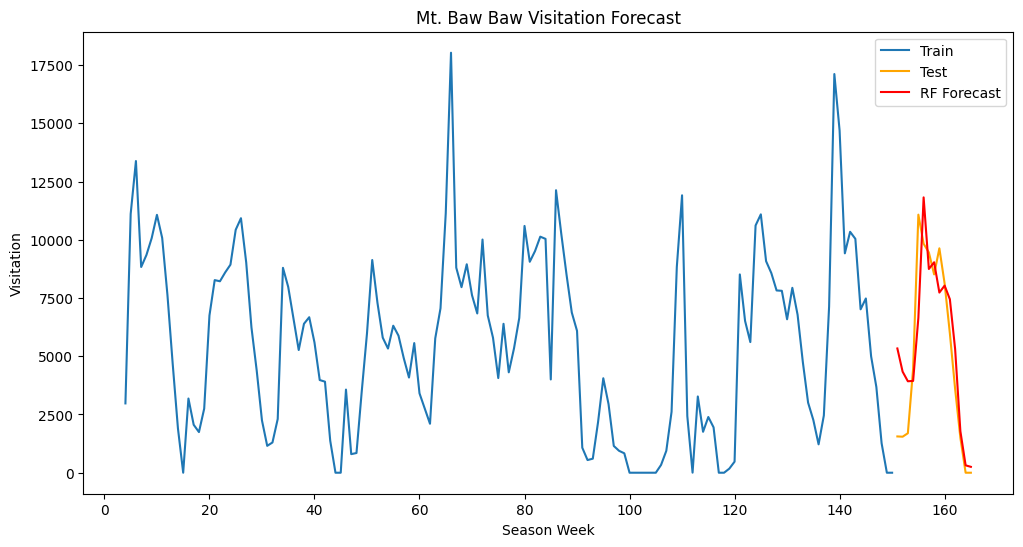

Mt. Stirling - MAE: 355.28, R^2: 0.59


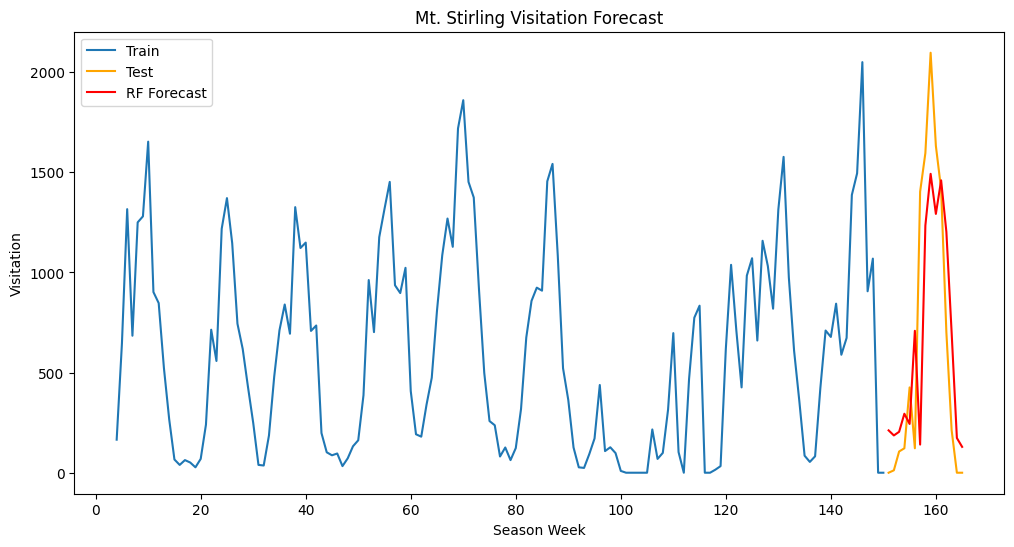

Mt. Hotham - MAE: 4766.02, R^2: 0.75


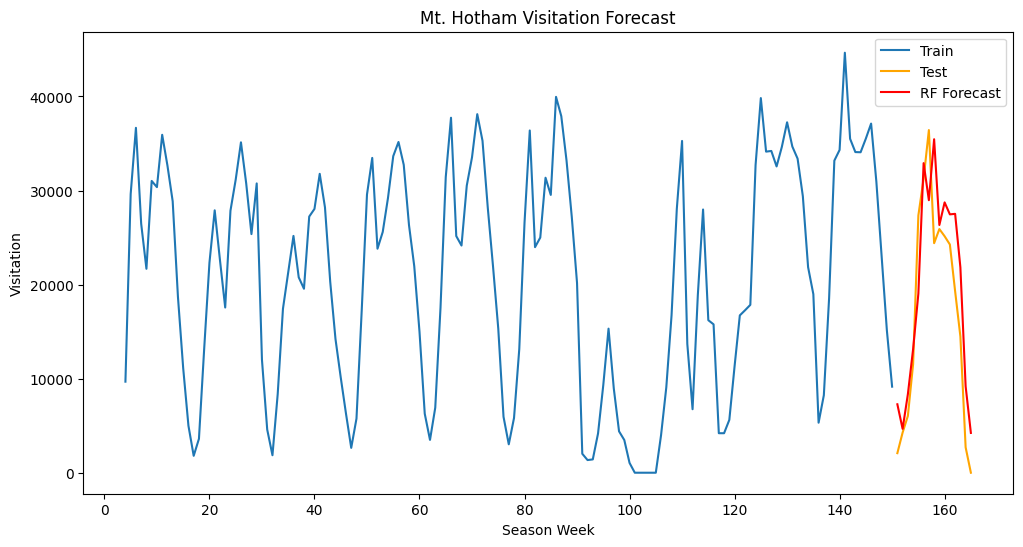

Falls Creek - MAE: 6153.59, R^2: 0.80


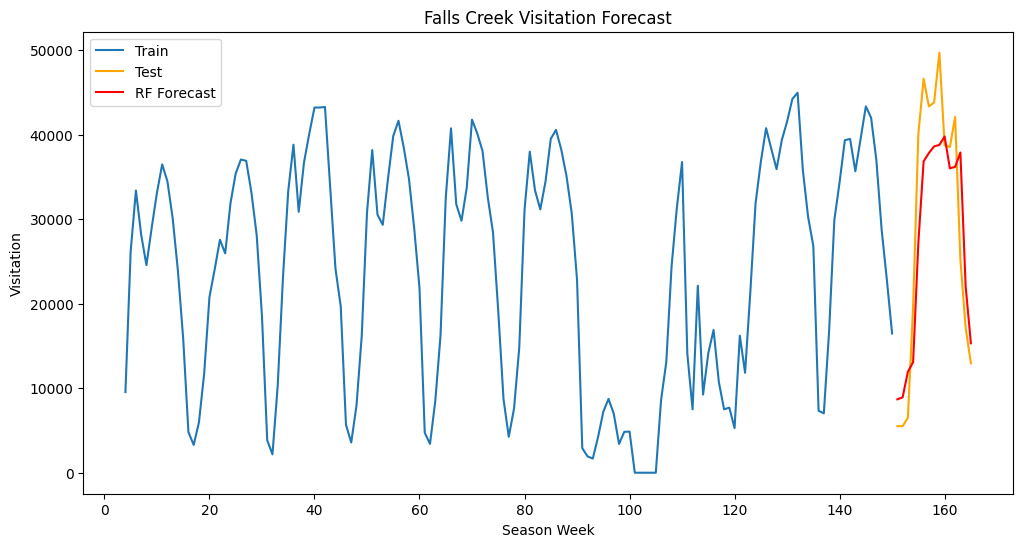

Mt. Buller - MAE: 7410.35, R^2: 0.81


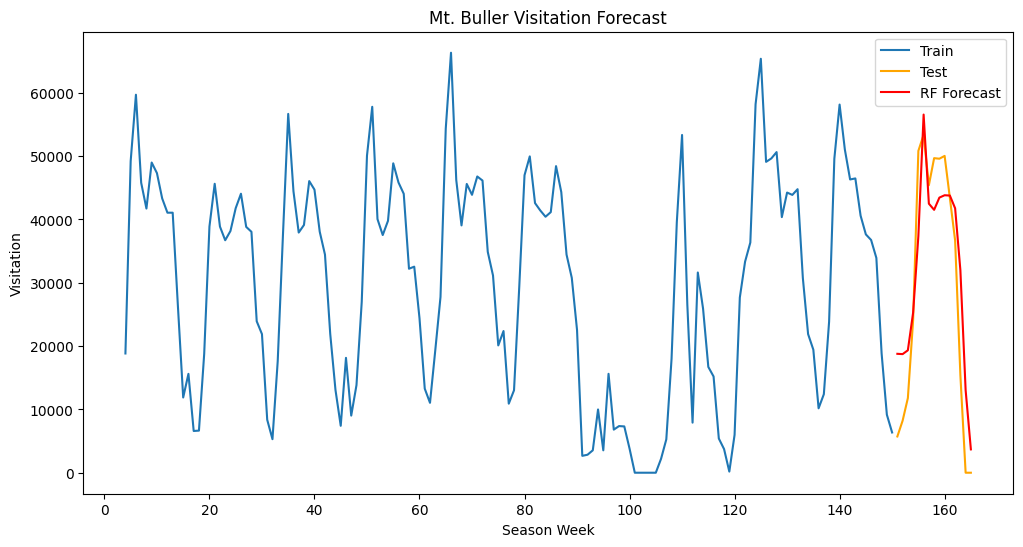

Selwyn - MAE: 1103.71, R^2: 0.85


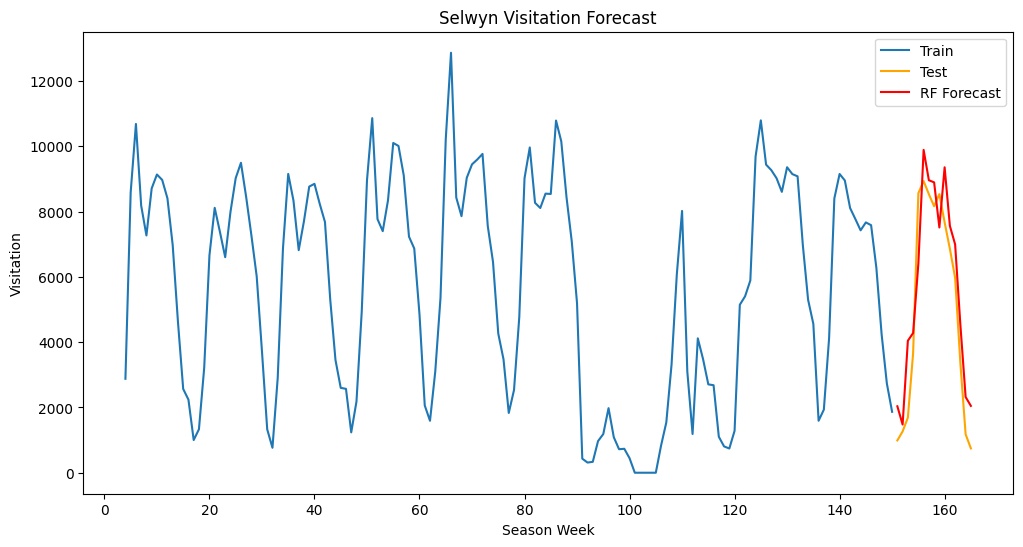

Thredbo - MAE: 5051.26, R^2: 0.88


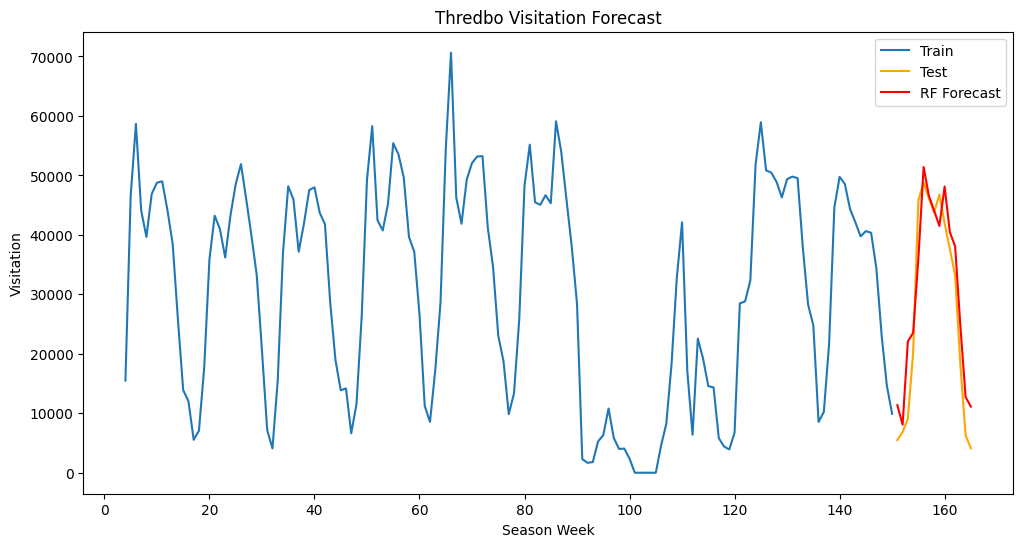

Perisher - MAE: 7187.91, R^2: 0.87


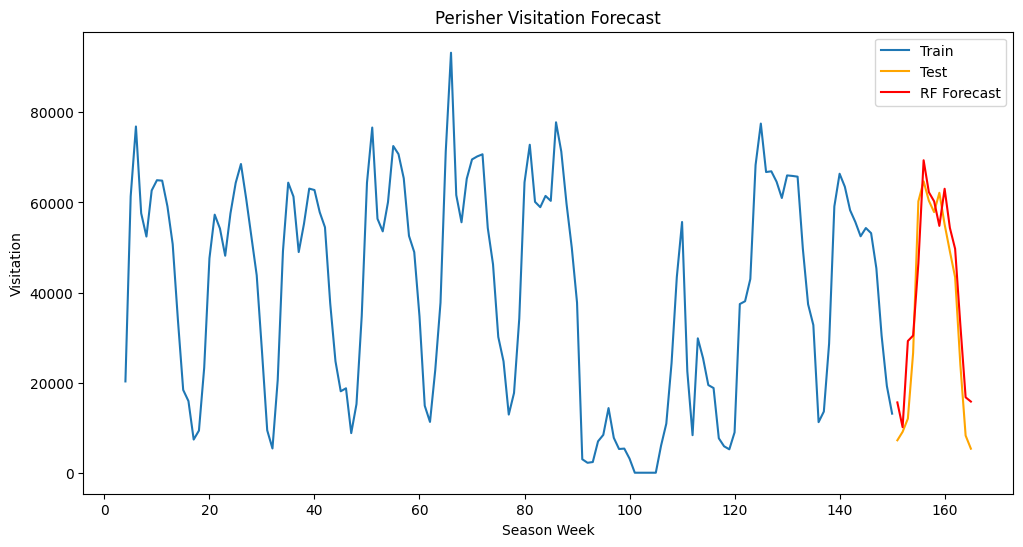

Charlotte Pass - MAE: 381.59, R^2: 0.87


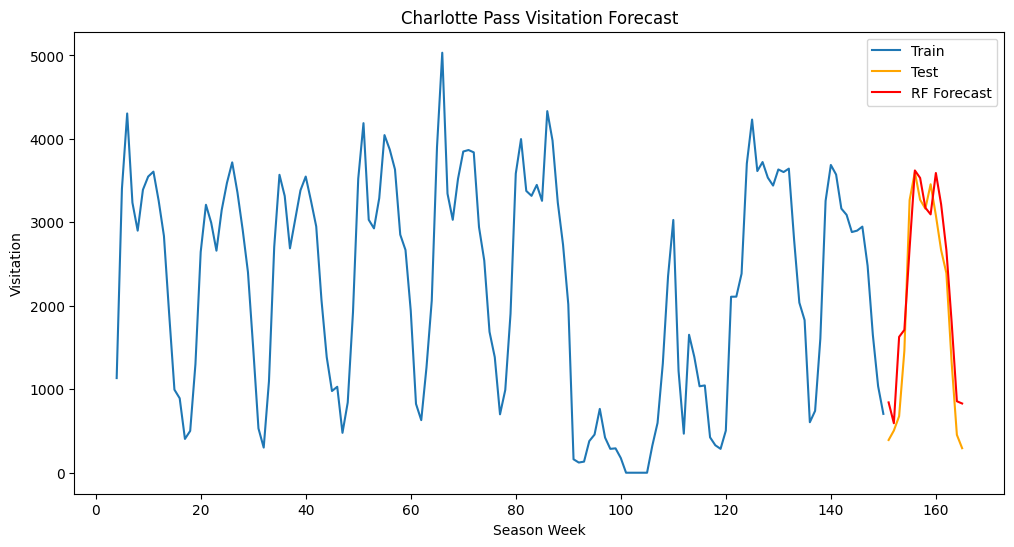

In [251]:
locations = {
    "Mt. Baw Baw": bawbaw,
    "Mt. Stirling": stirling,
    "Mt. Hotham": hotham,
    "Falls Creek": falls,
    "Mt. Buller": buller,
    "Selwyn": selwyn,
    "Thredbo": thredbo,
    "Perisher": perisher,
    "Charlotte Pass": charlotte
}

for name, data in locations.items():
    random_forest_forecast(data, name)

This code builds a Random Forest forecasting model to predict weekly ski resort visitation. It creates lag features from past visitation data, trains the model on historical records, and then forecasts the next 15 weeks. Finally, it evaluates performance with MAE and R², and plots the actual vs. predicted visitation for each resort.

In [268]:
def random_forest_forecast_future(df, resort_name, lags=3, forecast_weeks=30):
   
    df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")

    for lag in range(1, lags+1):
        df[f'visitation_lag_{lag}'] = df["visitation"].shift(lag)
    
    df_lagged = df.dropna()
    
    feature_cols = [f'visitation_lag_{lag}' for lag in range(1, lags+1)]
    X_train = df_lagged[feature_cols]
    y_train = df_lagged["visitation"]
    
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    last_row = df.iloc[-1:].copy()
    future_preds = []
    
    for i in range(forecast_weeks):
        X_last = last_row[feature_cols].copy()
        
        y_next = rf.predict(X_last)[0]
        future_preds.append(y_next)
        
        for lag in range(lags, 1, -1):
            last_row[f'visitation_lag_{lag}'] = last_row[f'visitation_lag_{lag-1}']
        last_row['visitation_lag_1'] = y_next
        
        last_row.index = [last_row.index[0] + 1]
    
    future_index = range(df.index[-1] + 1, df.index[-1] + 1 + forecast_weeks)
    forecast_weeks_list = [(i-1) % 15 + 1 for i in range(1, forecast_weeks+1)]  # weeks 1–15
    forecast_years_list = [2025 + ((i-1)//15) for i in range(1, forecast_weeks+1)]  # years
    
    df_future = pd.DataFrame({
        "Year": forecast_years_list,
        "Week": forecast_weeks_list,
        "visitation": future_preds
    }, index=future_index)

    df_future = df_future[df_future["Year"] == 2026]

    week_to_date = {
        1: "9-Jun",  2: "16-Jun",  3: "23-Jun",  4: "30-Jun",
        5: "7-Jul",  6: "14-Jul",  7: "21-Jul",  8: "28-Jul",
        9: "4-Aug",  10: "11-Aug", 11: "18-Aug", 12: "25-Aug",
        13: "1-Sep", 14: "8-Sep",  15: "15-Sep"
    }
    
    df_future["date_label"] = df_future["Week"].map(week_to_date)

    plt.figure(figsize=(10,5))
    plt.plot(df_future["date_label"], df_future["visitation"], color="red", marker="o", label="2026 Forecast")
    plt.xticks(rotation=45)
    plt.xlabel("Date (2026 Season)")
    plt.ylabel("Visitation")
    plt.title("Mt. Buller 2026 Visitation Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

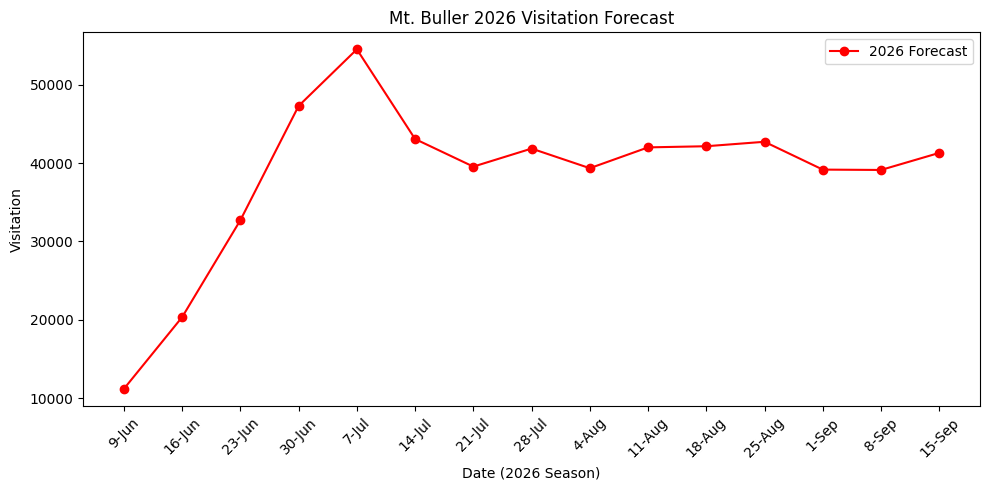

In [269]:
random_forest_forecast_future(buller, "Mt. Buller")

This function trains a Random Forest on past visitation values with lag features, then recursively forecasts 30 weeks into the future. The forecasted values are mapped into corresponding 2026 season weeks (June–September) and labeled with calendar-style dates. Finally, it plots only the 2026 visitation forecast as a red line chart with readable week/date labels.

In [280]:
def random_forest_forecast_future2(df, resort_name, lags=3, forecast_weeks=30):
    
    df = df.copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")

    for lag in range(1, lags+1):
        df[f'visitation_lag_{lag}'] = df["visitation"].shift(lag)
    
    df_lagged = df.dropna()
    
    feature_cols = [f'visitation_lag_{lag}' for lag in range(1, lags+1)]
    X_train = df_lagged[feature_cols]
    y_train = df_lagged["visitation"]
    
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    last_row = df.iloc[-1:].copy()
    future_preds = []
    
    for i in range(forecast_weeks):
        X_last = last_row[feature_cols].copy()
        
        y_next = rf.predict(X_last)[0]
        future_preds.append(y_next)
        
        for lag in range(lags, 1, -1):
            last_row[f'visitation_lag_{lag}'] = last_row[f'visitation_lag_{lag-1}']
        last_row['visitation_lag_1'] = y_next
        
        last_row.index = [last_row.index[0] + 1]
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    future_index = np.arange(df.index[-1]+1, df.index[-1]+1+forecast_weeks)
    plt.plot(future_index, future_preds, label="RF Forecast", color="red")
    plt.title(f"{resort_name} Visitation Forecast (No Weather)")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()

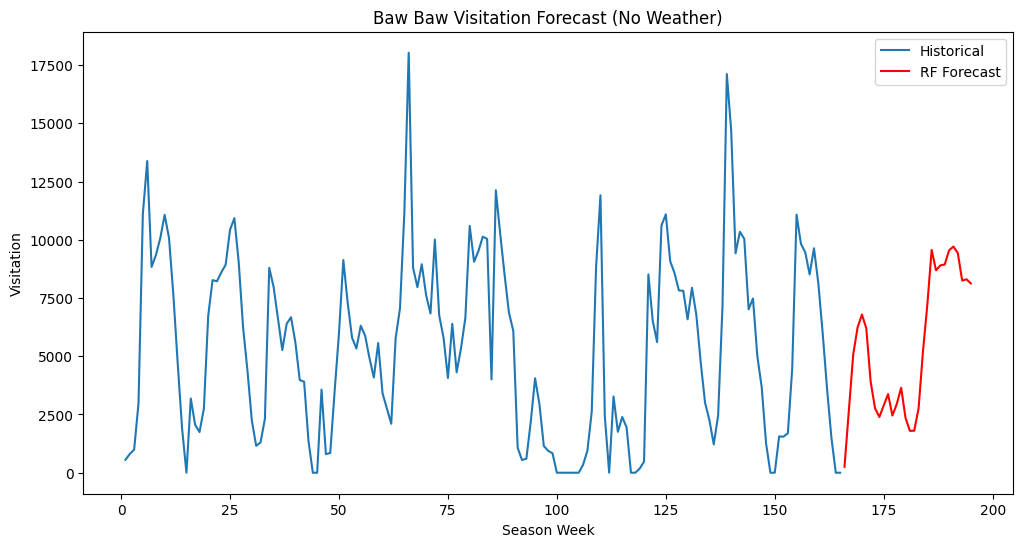

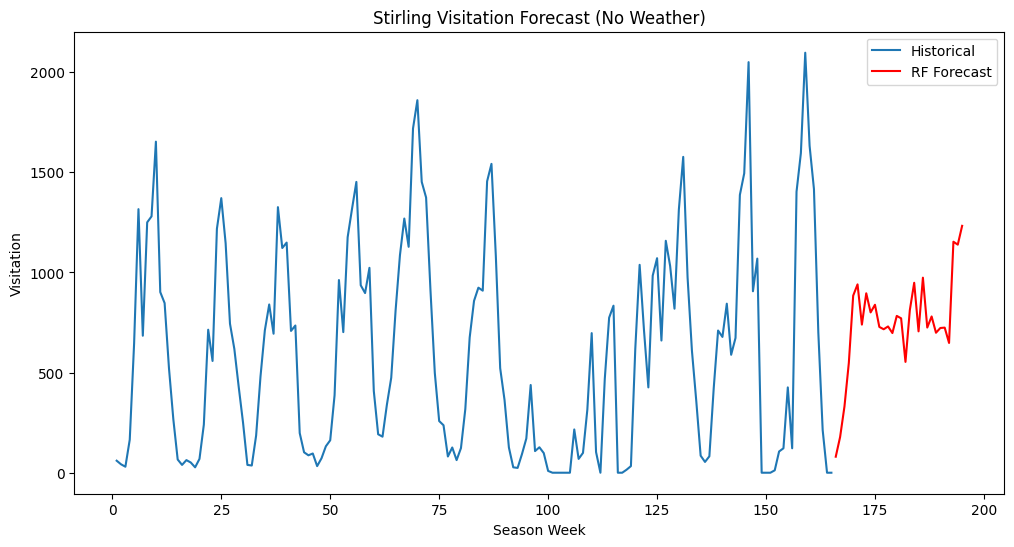

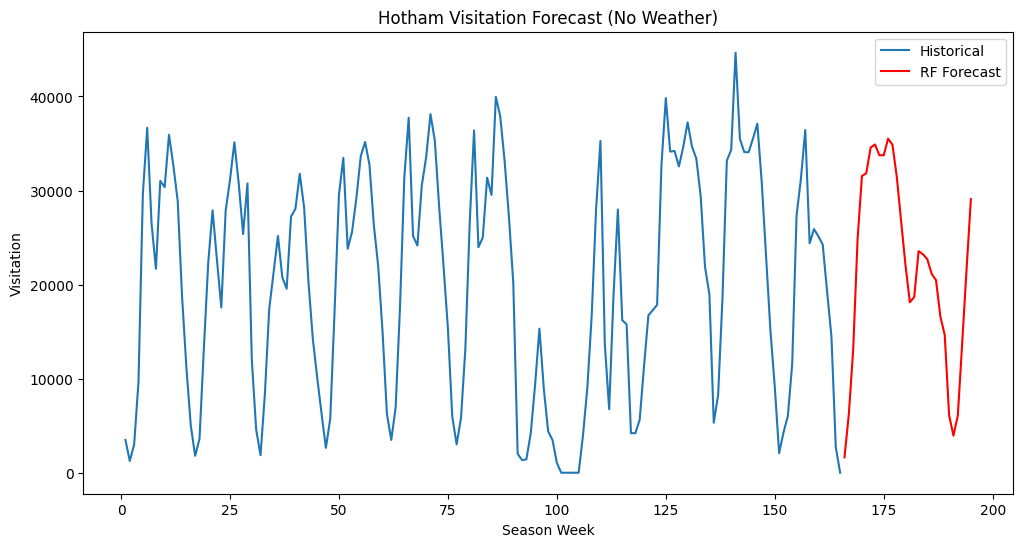

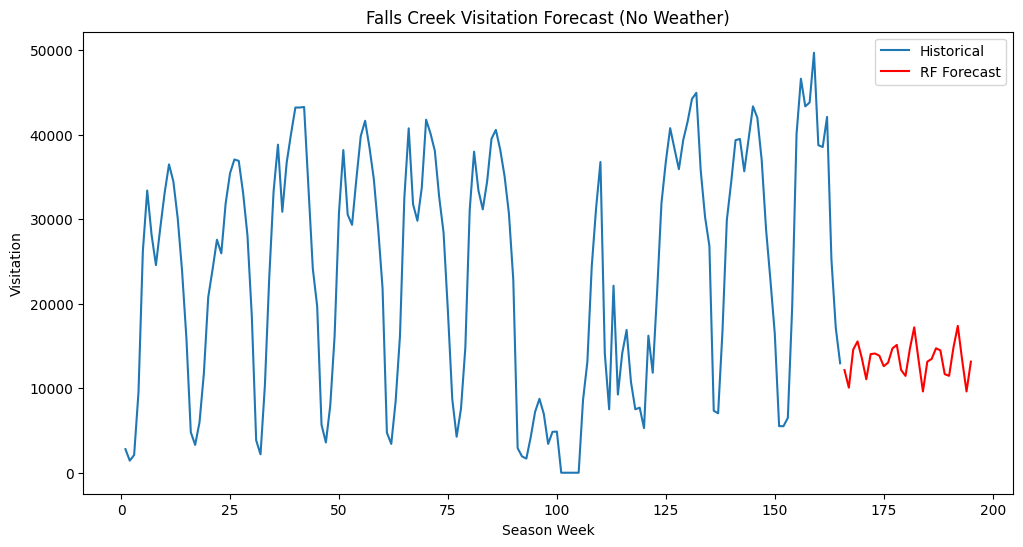

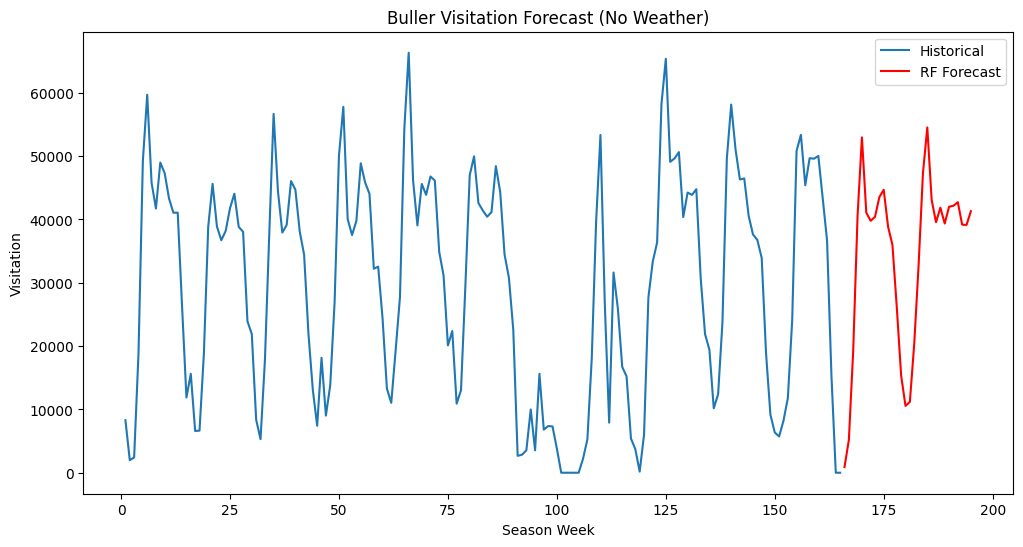

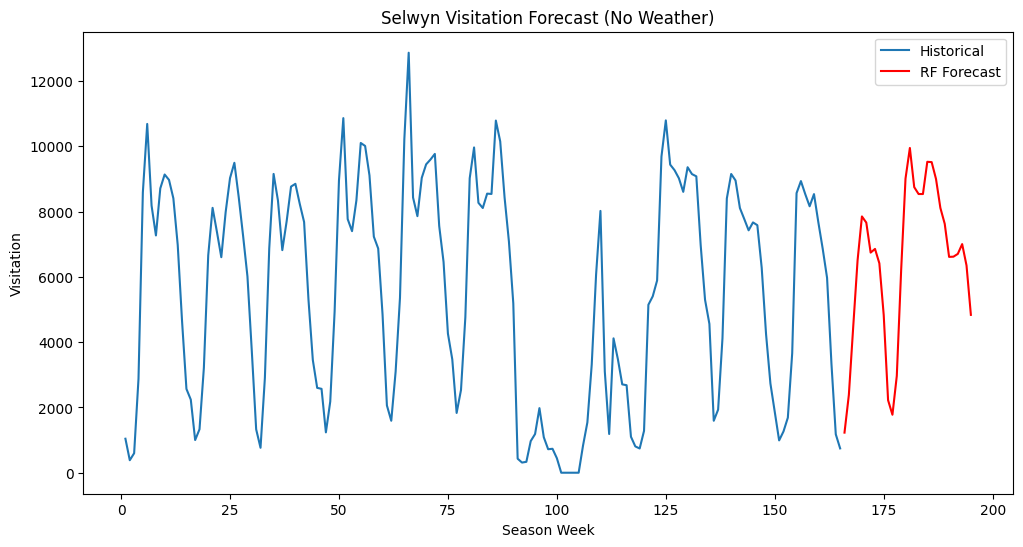

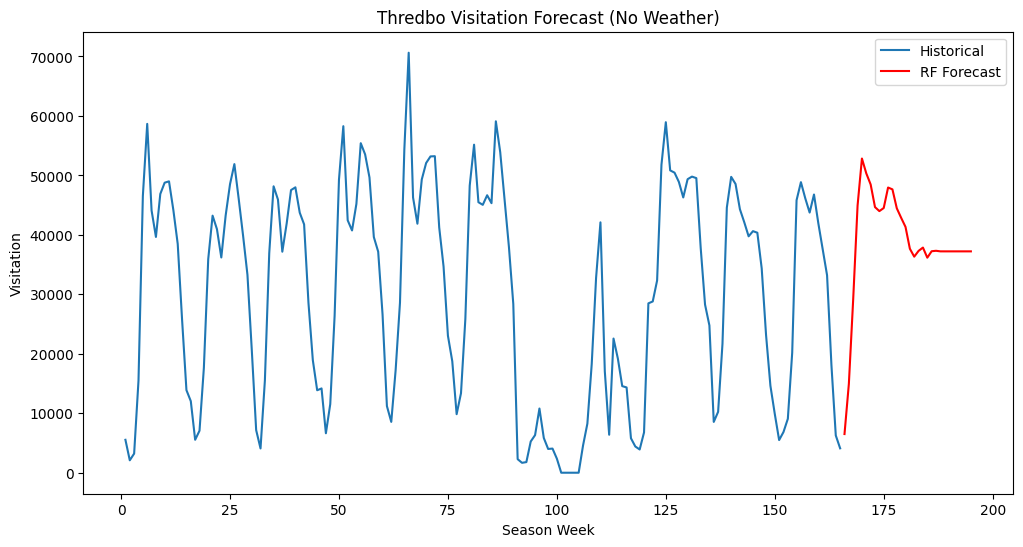

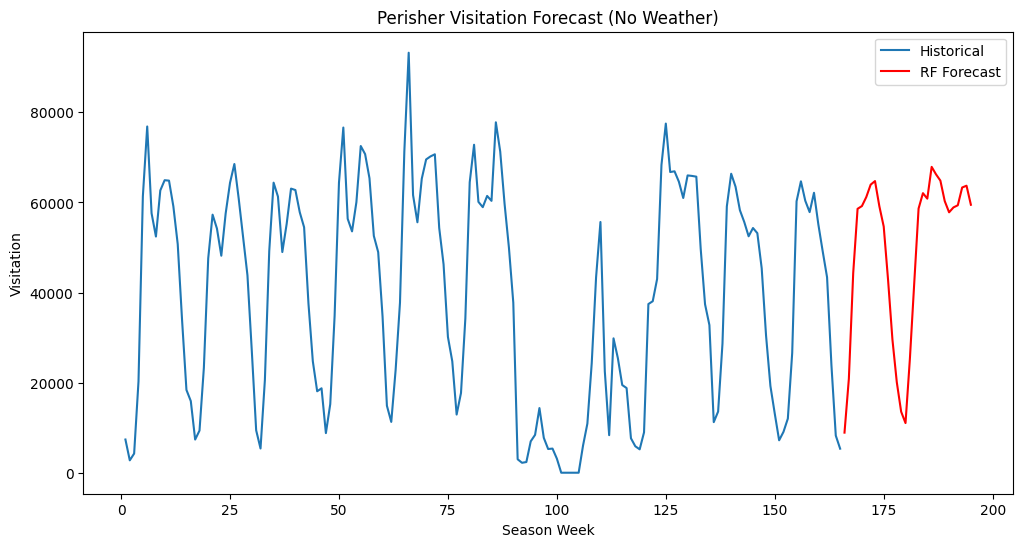

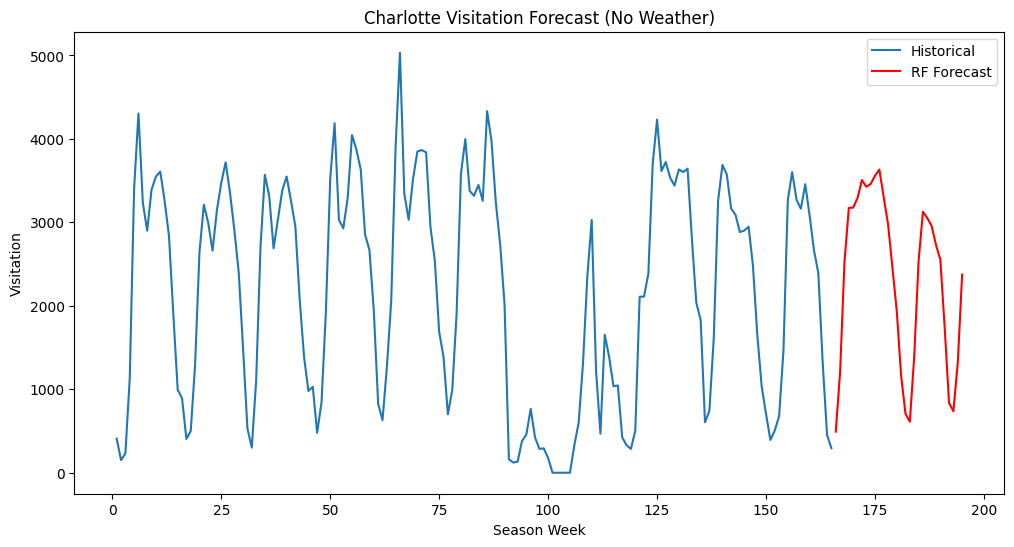

In [283]:
locations = {
    "Baw Baw": bawbaw,
    "Stirling": stirling,
    "Hotham": hotham,
    "Falls Creek": falls,
    "Buller": buller,
    "Selwyn": selwyn,
    "Thredbo": thredbo,
    "Perisher": perisher,
    "Charlotte": charlotte
}

for name, data in locations.items():
    random_forest_forecast_future2(data, name)

This version trains a Random Forest on lagged visitation values and generates recursive forecasts for the next 30 weeks. It then combines historical visitation with the predicted future values to show both trends together. The output is a line plot where the historical data is in blue and the forecast is highlighted in red.

# Exponential Smoothing (Not Great Model)

In [152]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [136]:
perisher_data = perisher.iloc[:, :3]
perisher_data = peri

Year  Week  visitation
0    2014.0   1.0      7370.0
1    2014.0   2.0      2751.0
2    2014.0   3.0      4255.0
3    2014.0   4.0     20265.0
4    2014.0   5.0     61339.0
..      ...   ...         ...
160  2024.0  11.0     49136.0
161  2024.0  12.0     43382.0
162  2024.0  13.0     23908.0
163  2024.0  14.0      8244.0
164  2024.0  15.0      5336.0

[165 rows x 3 columns]

In [142]:
perisher_data["season_week"] = (perisher_data["Year"].astype(int) - 2014) * 15 + perisher_data["Week"]
perisher_data = perisher_data.set_index("season_week")

In [159]:
def holt_winters_forecast(df, location_name, seasonal_periods=15, test_weeks=15):
    
    df = df.copy()
    df["season_week"] = (df["Year"].astype(int) - df["Year"].min()) * seasonal_periods + df["Week"]
    df = df.set_index("season_week")
    
    train = df.iloc[:-test_weeks]
    test = df.iloc[-test_weeks:]
    
    model = ExponentialSmoothing(
        train["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods
    ).fit()
    
    forecast = model.forecast(steps=test_weeks)
    
    mae = mean_absolute_error(test["visitation"], forecast)
    r2 = r2_score(test["visitation"], forecast)
    
    print(f"📍 {location_name}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train["visitation"], label="Train")
    plt.plot(test.index, test["visitation"], label="Test", color="orange")
    plt.plot(test.index, forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name}")
    plt.legend()
    plt.show()
    
    

📍 Baw Baw
MAE: 2326.02
R²: 0.39


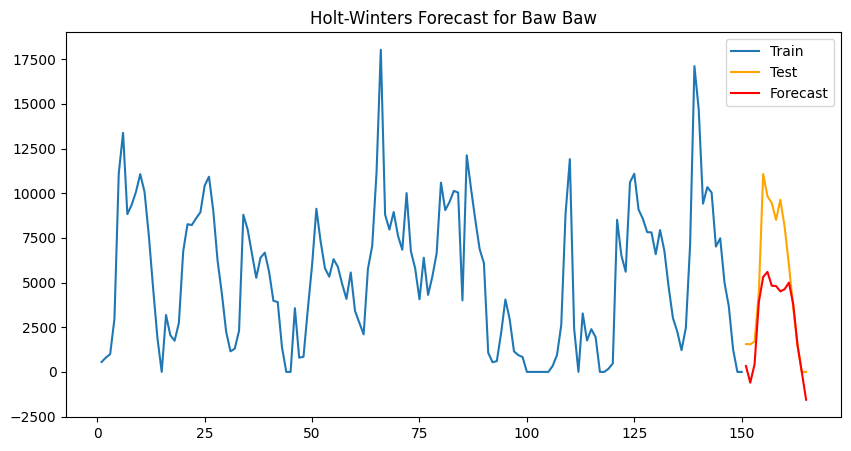

📍 Stirling
MAE: 371.06
R²: 0.46


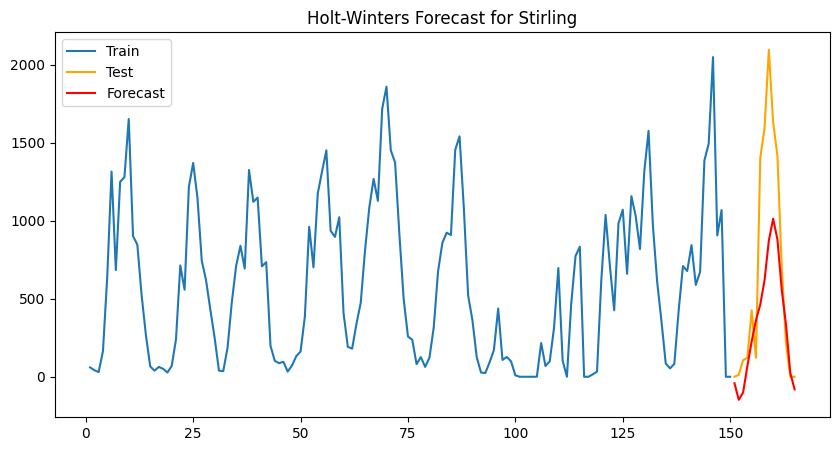

📍 Hotham
MAE: 5629.02
R²: 0.61


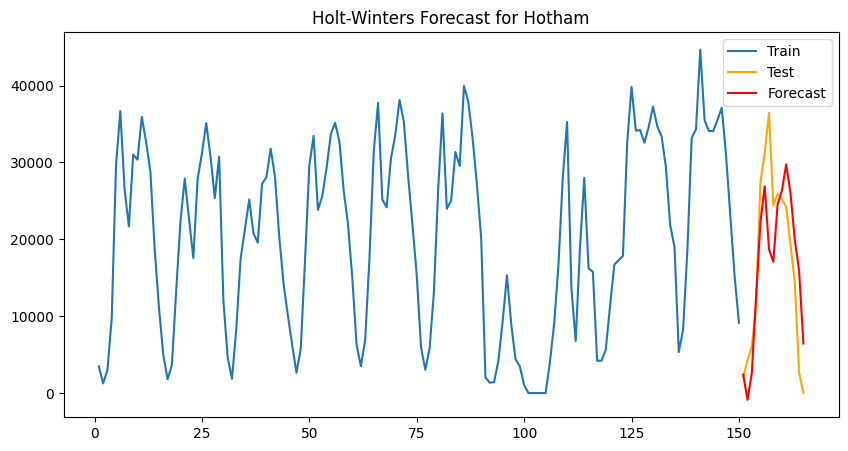

📍 Falls Creek
MAE: 8104.00
R²: 0.60


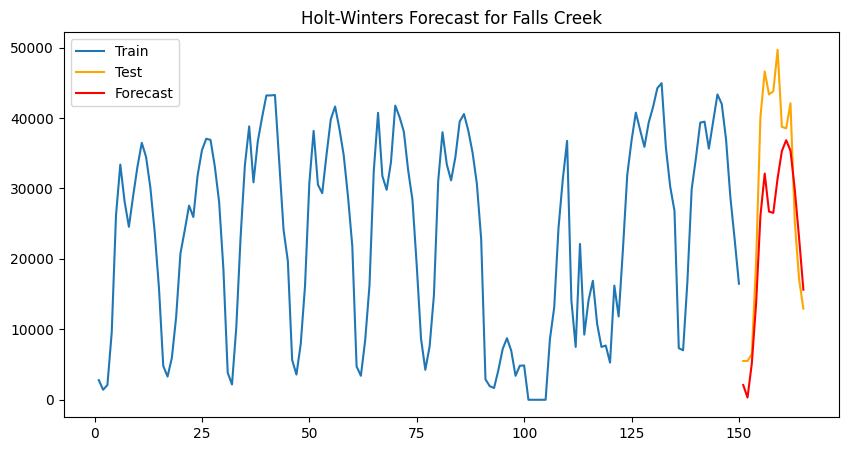

📍 Buller
MAE: 12052.84
R²: 0.54


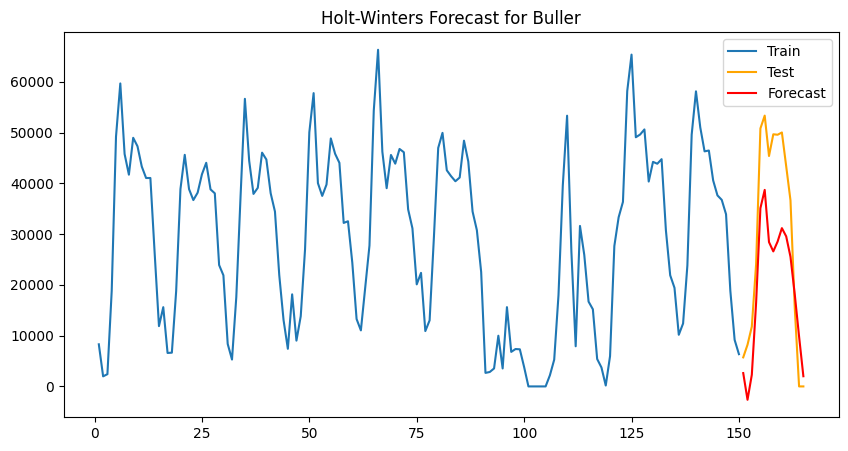

📍 Selwyn
MAE: 1242.81
R²: 0.78


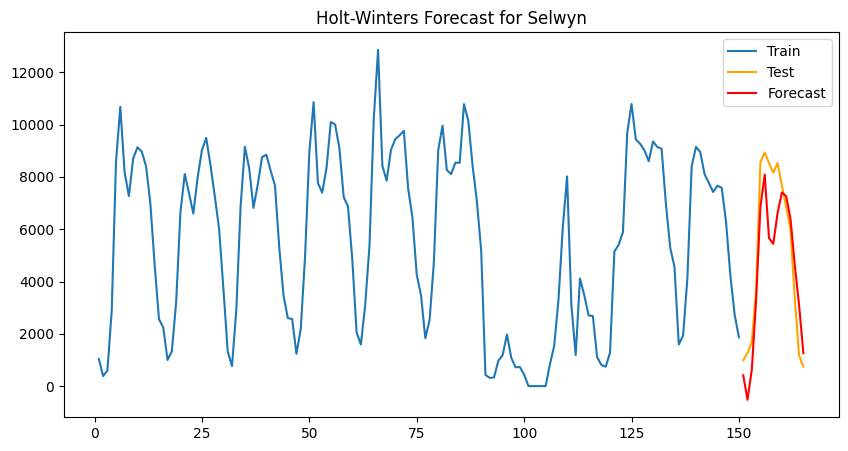

📍 Thredbo
MAE: 6870.58
R²: 0.77


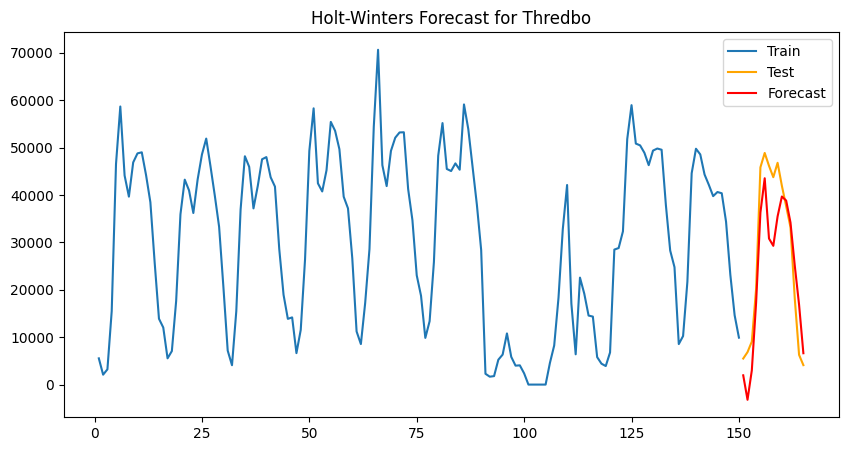

📍 Perisher
MAE: 8960.95
R²: 0.78


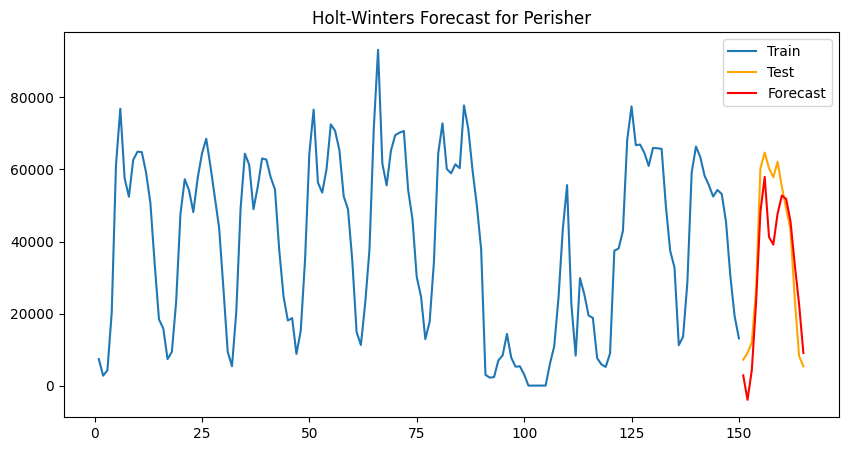

📍 Charlotte
MAE: 562.27
R²: 0.74


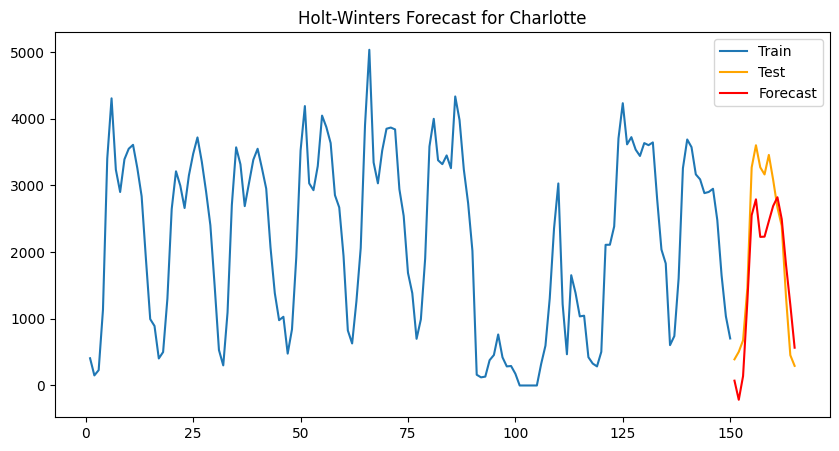

In [284]:
for name, data in locations.items():
    holt_winters_forecast(data, name)

This function applies the Holt-Winters exponential smoothing model to each resort’s visitation data, capturing both trend and seasonality. It trains on historical values, forecasts the next 15 weeks, and evaluates performance with MAE and R². The output includes a plot comparing training data, test data, and the forecast in red for each location.

In [176]:
def holt_winters_forecast_future(df, location_name, steps=30):
    
    df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    model = ExponentialSmoothing(
        df["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=15
    ).fit()
    
    forecast = model.forecast(steps=steps)
    
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    plt.plot(range(df.index[-1]+1, df.index[-1]+1+steps), forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name}")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()
    
    return forecast

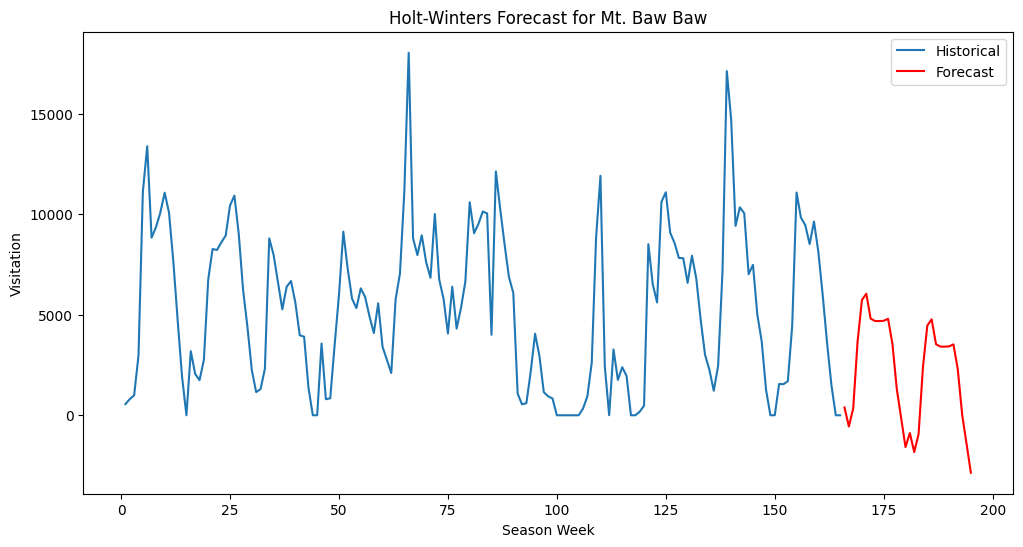

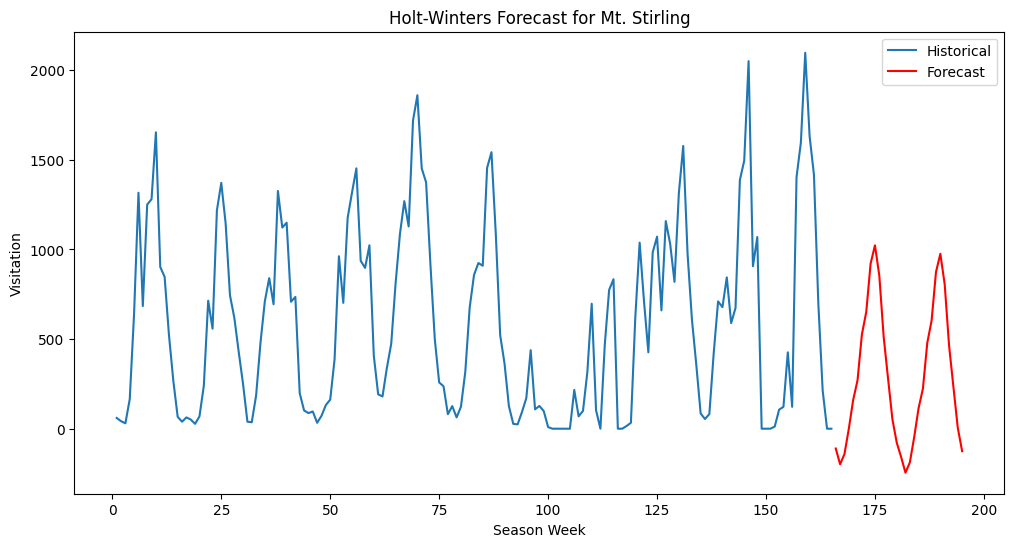

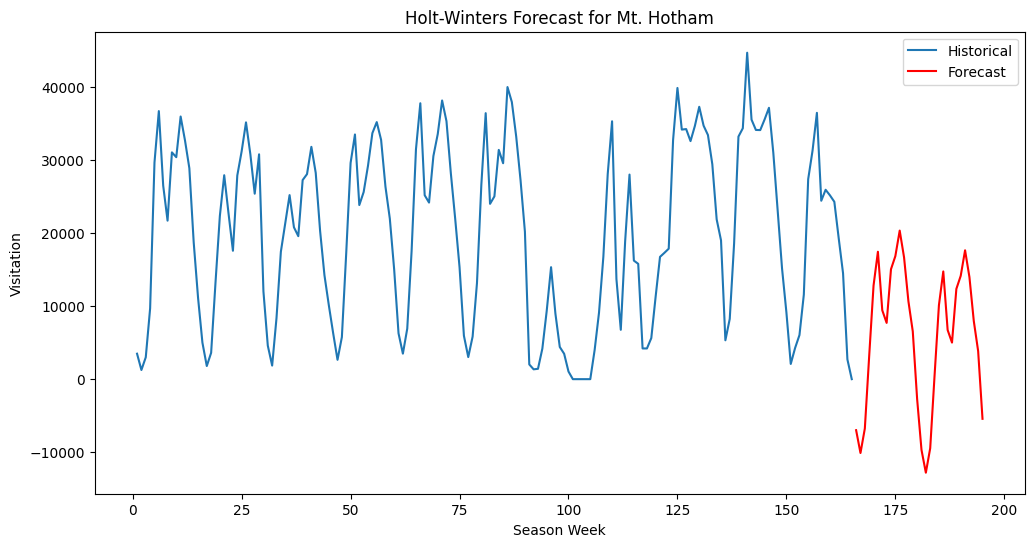

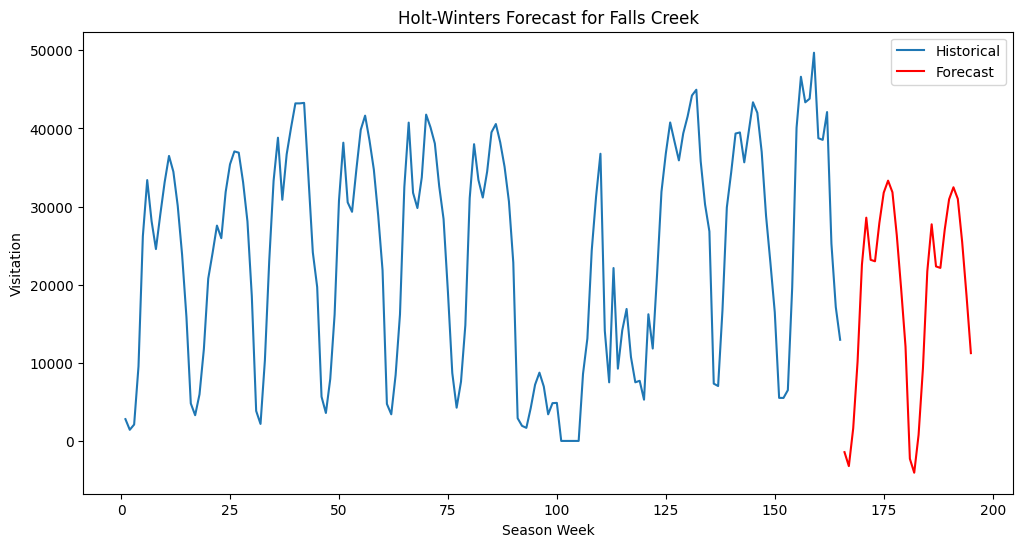

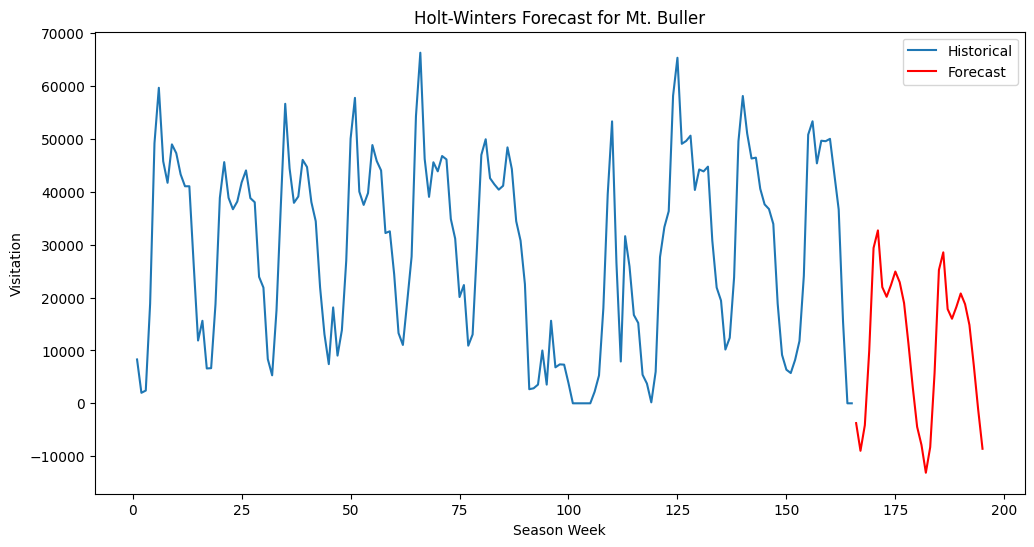

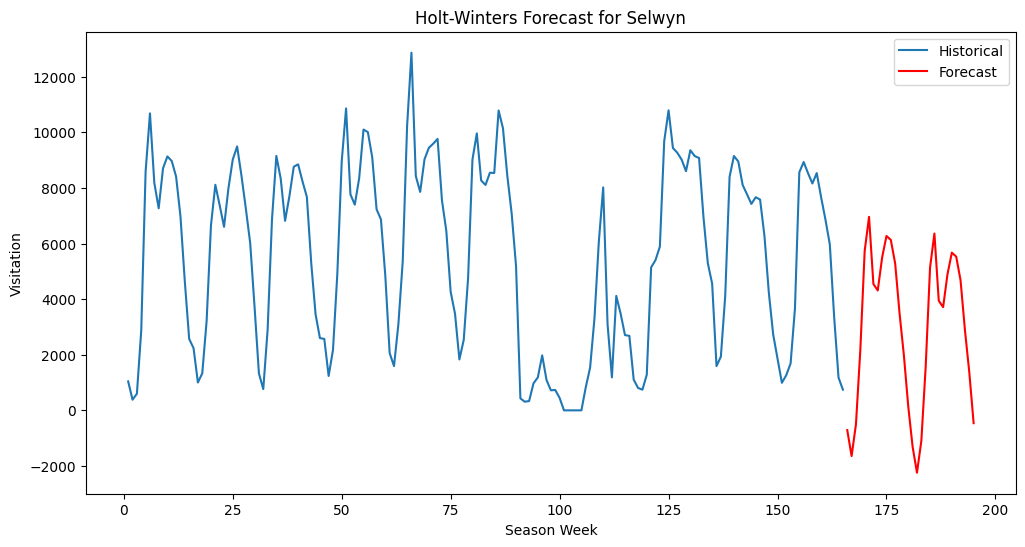

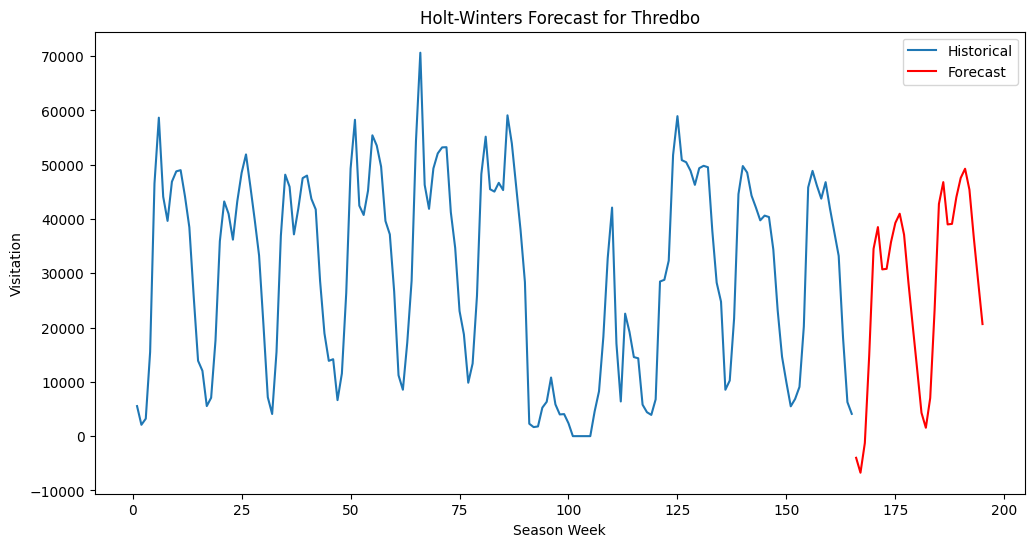

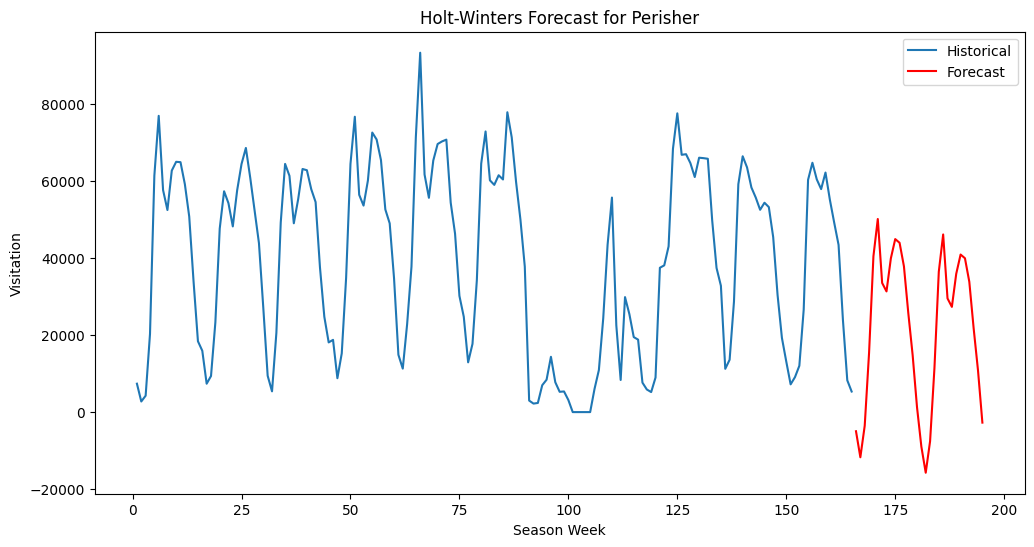

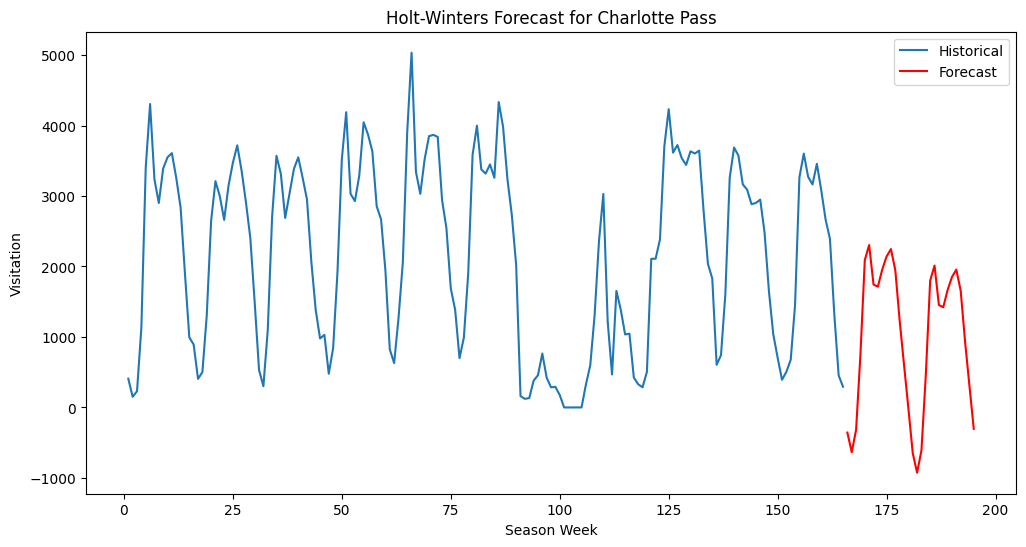

In [177]:
for name, data in locations.items():
    holt_winters_forecast_future(data, name, steps=30)

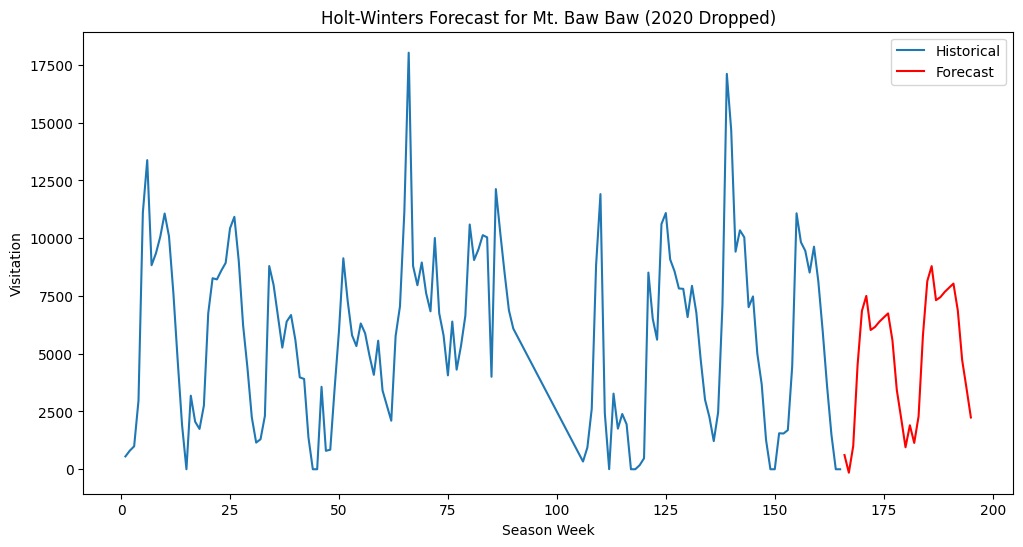

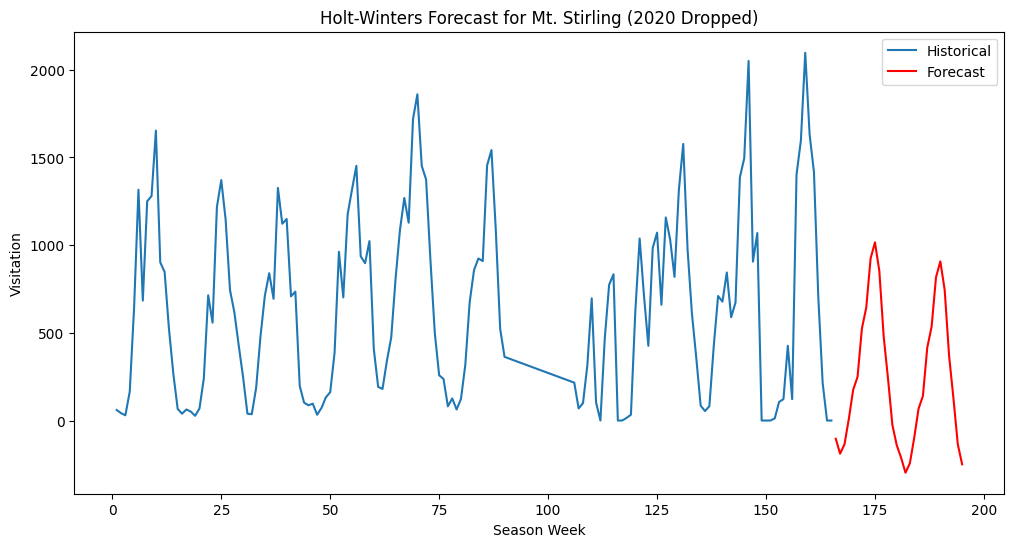

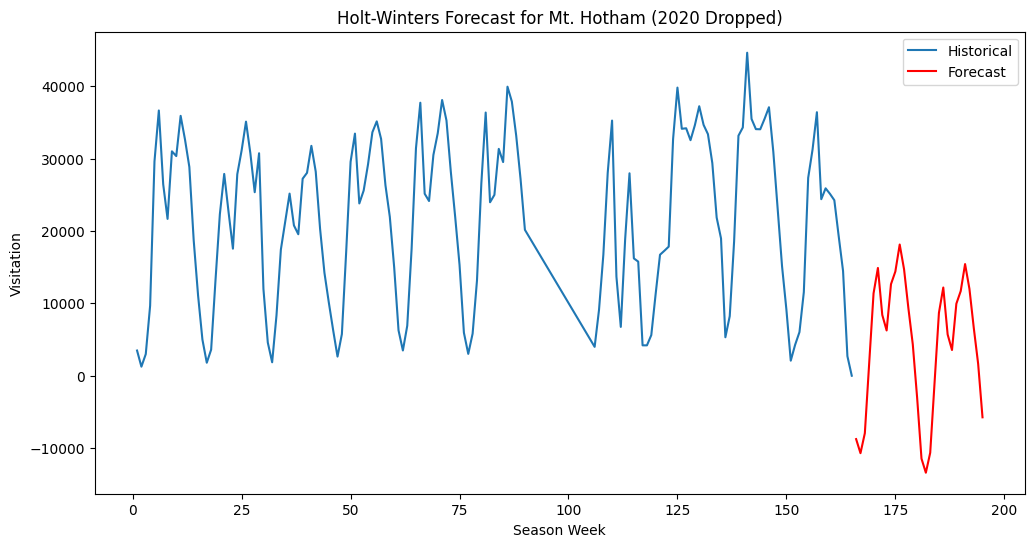

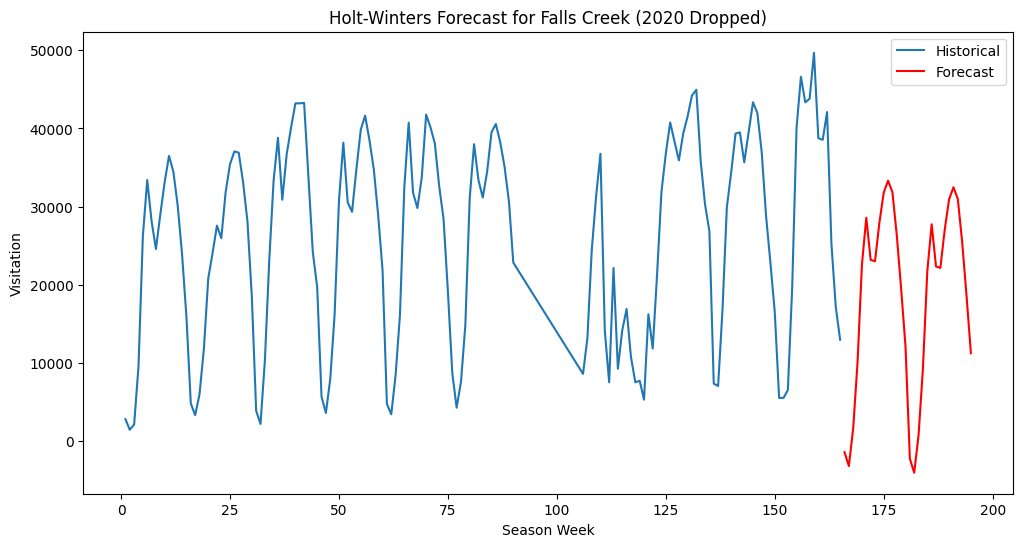

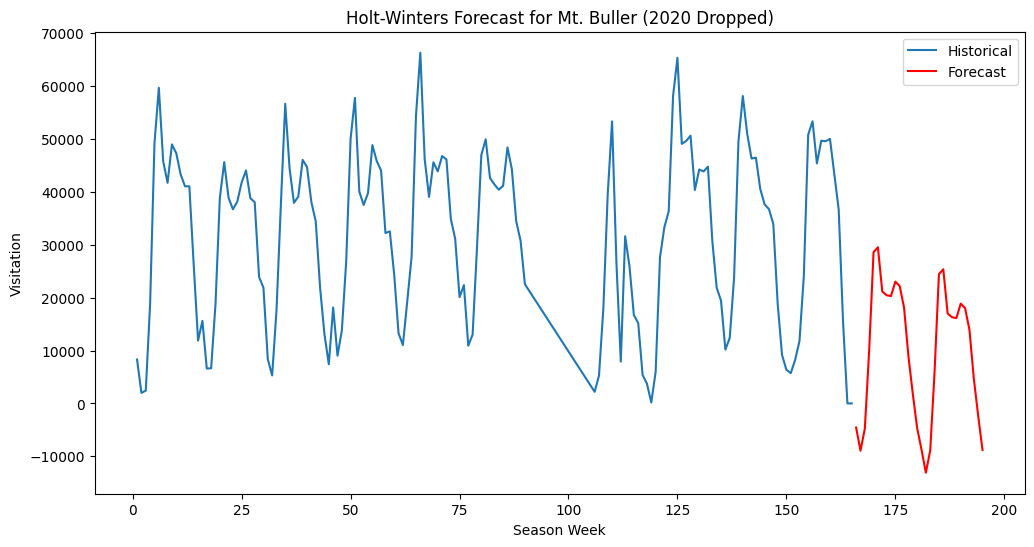

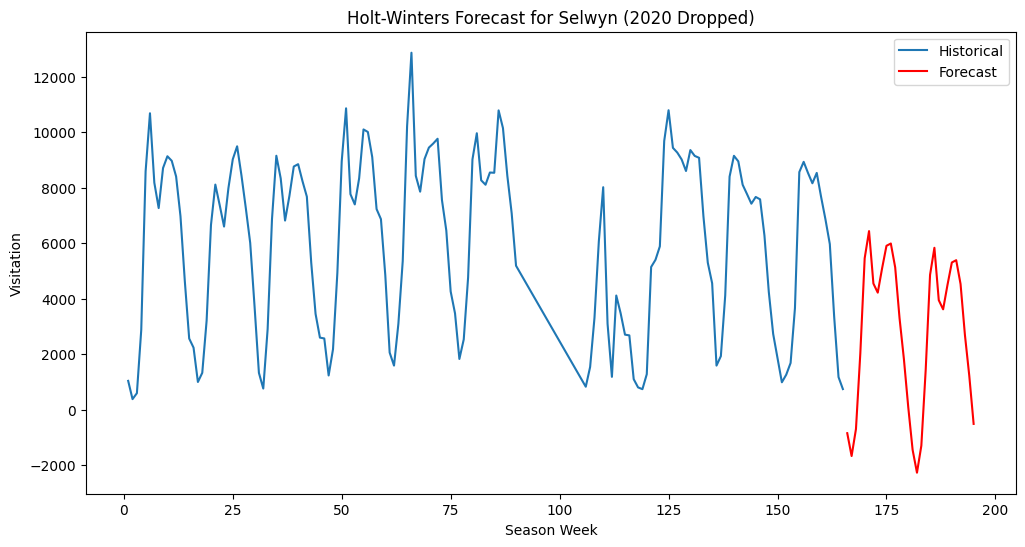

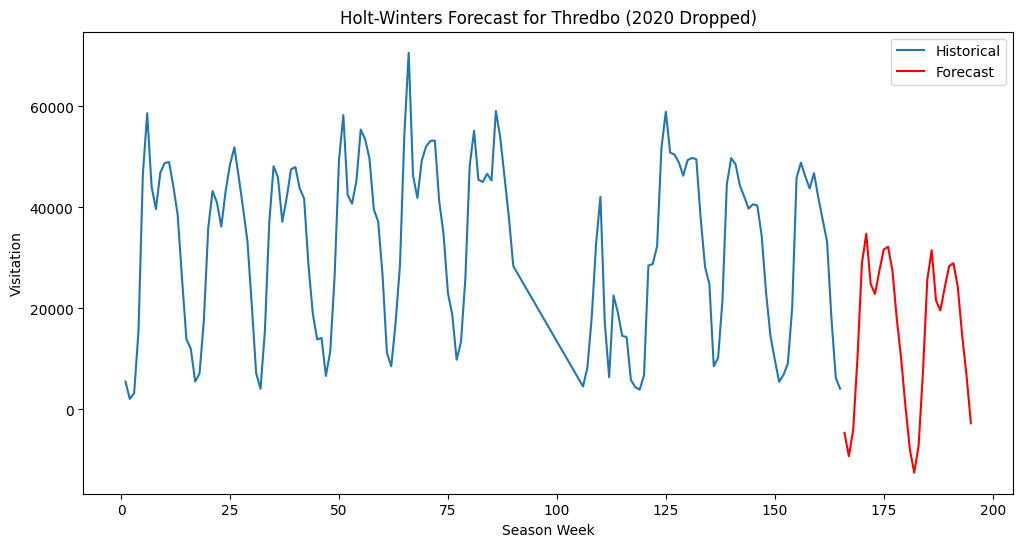

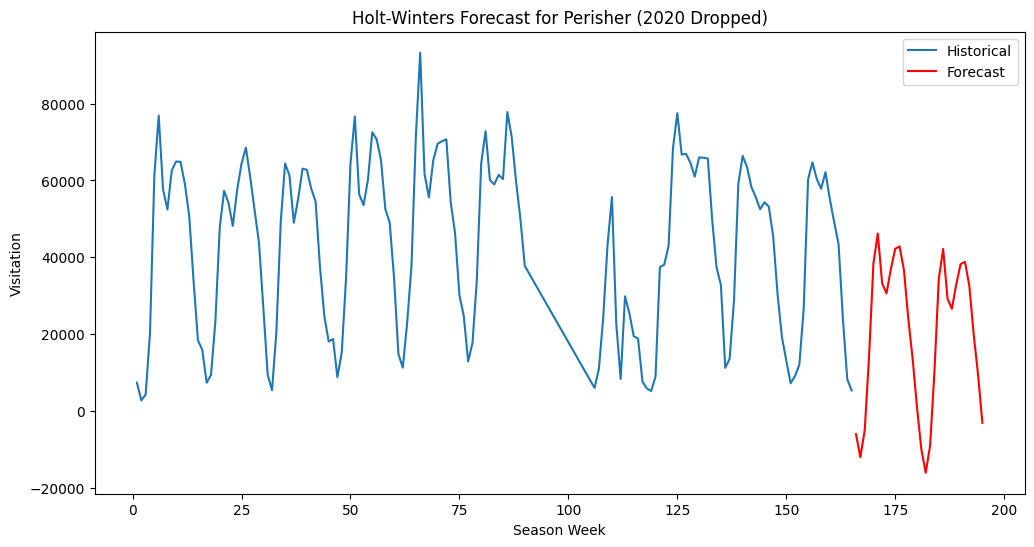

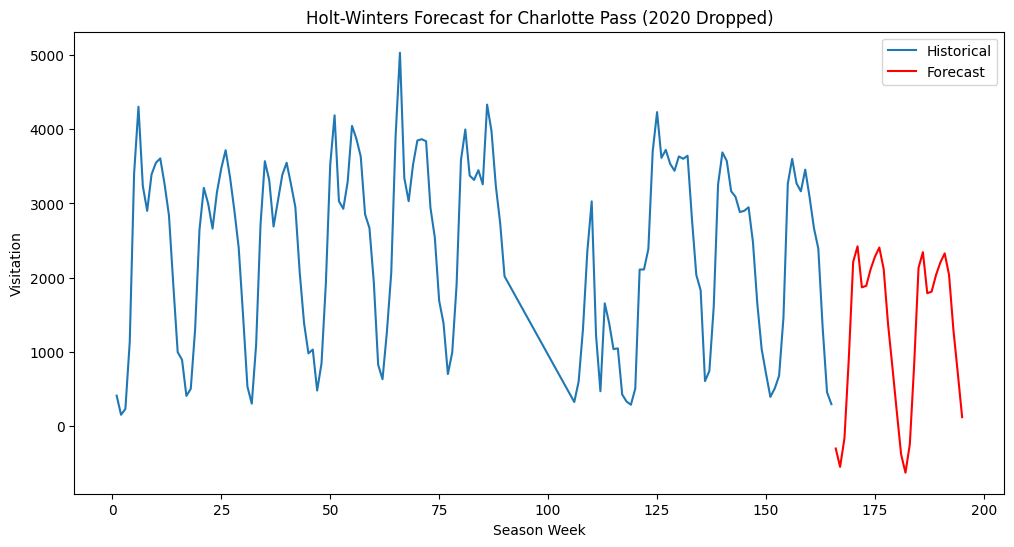

In [182]:
for name, data in locations.items():
    holt_winters_forecast_future2(data, name, steps=30)

In [181]:
def holt_winters_forecast_future2(df, location_name, steps=30):
    # Prepare data
    df = df[df["Year"] != 2020].copy()
    #df = df.iloc[:, :3].copy()
    df["season_week"] = ((df["Year"].astype(int) - 2014) * 15 + df["Week"]).astype(int)
    df = df.set_index("season_week")
    
    # Fit Holt-Winters on all data
    model = ExponentialSmoothing(
        df["visitation"],
        trend="add",
        seasonal="add",
        seasonal_periods=15
    ).fit()
    
    # Forecast next 'steps' periods
    forecast = model.forecast(steps=steps)
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["visitation"], label="Historical")
    plt.plot(range(df.index[-1]+1, df.index[-1]+1+steps), forecast, label="Forecast", color="red")
    plt.title(f"Holt-Winters Forecast for {location_name} (2020 Dropped)")
    plt.xlabel("Season Week")
    plt.ylabel("Visitation")
    plt.legend()
    plt.show()
    
    return forecast